In [ ]:
using ITensors
ITensors.enable_debug_checks()

**Initialization script(netcon)**

In [ ]:
function netcon(tensor_list,connect_list_in;con_order=[],check_network=true,)
    #copying the original information to avoid losing it
    connect_list=deepcopy(connect_list_in)
    if (tensor_list[1] isa Real)|(tensor_list[1] isa Complex)
        tensor_list=Any[tensor_list]
    end
    if !(connect_list[1] isa Array)
        connect_list=Any[connect_list]
    end
    #generate contraction order
    flat_connect=vcat(connect_list...)
    if isempty(con_order)
        con_order=sort(unique(flat_connect[flat_connect.>0]))
    end
    if check_network
        dims_list = Array{Any,1}(undef, length(tensor_list))
        for ik = 1:length(tensor_list)
            dims_list[ik] = [size(tensor_list[ik])...]
        end
            check_inputs(connect_list,flat_connect,dims_list,con_order)
    end
    for i in 1:length(connect_list)
        num_count=length(connect_list[i])-length(unique(connect_list[i]))
        if num_count>0
            tensor_list[i],connect_list[i],cont_label=partial_trace(tensor_list[i],connect_list[i])
            con_order=setdiff(con_order,cont_label)
        end
    end
    #binary contractions
    while !isempty(con_order)
        #identifying tensors to be contracted
        cont_ind=con_order[1]
        locs=[ele for ele in collect(1:length(connect_list)) if sum(connect_list[ele] .==cont_ind)>0]
        cont_many=intersect(connect_list[locs[1]],connect_list[locs[2]])
        Acont=[findfirst(connect_list[locs[1]].==x) for x in cont_many]
        Bcont=[findfirst(connect_list[locs[2]].==x) for x in cont_many]
        Afree=deleteat!(collect(1:length(connect_list[locs[1]])),sort(Acont))
        Bfree=deleteat!(collect(1:length(connect_list[locs[2]])),sort(Bcont))
        push!(tensor_list,tensordot(tensor_list[locs[1]],tensor_list[locs[2]],Acont,Bcont,),)
        push!(connect_list,vcat(connect_list[locs[1]][Afree],connect_list[locs[2]][Bfree]))
        deleteat!(connect_list,locs)
        deleteat!(tensor_list,locs)
        con_order=setdiff(con_order,cont_many)
    end
    #outer products
    while length(tensor_list)>1
        s1=size(tensor_list[end-1])
        s2=size(tensor_list[end])
        tensor_list[end-1]=reshape(
            reshape(tensor_list[end-1],prod(s1))*
            reshape(tensro_list[end],prod,s2),
            (s1...,s2...),
        )
        connect_list[end-1]=vvcat(connect_list[end-1],connect_list[end])
        deleteat!(connect_list,length(connect_list))
        deleteat!(tensor_list,length(tensor_list))
    end
    #final permutation
    if length(connect_list[1])>0
            return permutedims(tensor_list[1],sortperm(connect_list[1],by=abs))
    else
        return tensor_list[1][1]
    end
end


netcon (generic function with 1 method)

**Optimization script(ncon)**

In [ ]:
function tensordot(A,B,A_cont,B_cont)
    Afree=deleteat!(collect(1:ndims(A)),sort(A_cont))
    Bfree=deleteat!(collect(1:ndims(B)),sort(B_cont))
    A_perm=vcat(Afree,A_cont)
    B_perm=vcat(B_cont,Bfree)
    return reshape(
        reshape(
            permutedims(A,A_perm),
            prod(size(A)[Afree]),
            prod(size(A)[A_cont]),
        )*
        reshape(
            permutedims(B,B_perm),
            prod(size(B)[B_cont]),
            prod(size(B)[Bfree]),
        ),
        (size(A)[Afree]...,size(B)[Bfree]...),
    )
end

tensordot (generic function with 1 method)

In [ ]:
#partial trace function
"""
function partial trace is for over repeated indices
"""
function partial_trace(A,Alabel)
    num_count=length(A)-length(unique(Alabel))
    Adims=size(A)
    if num_count>0
        dup_list=[]
        for ele in unique(Alabel)
            if sum(Alabel.==ele)>1
                dup_list=vcat(dup_list,findall(Alabel.==ele))
            end
        end
        cont_ind=reshape(permutedims(reshape(dup_list,2,num_count),[2,1]),2*num_count)
        free_ind=deleteat!(collect(1:length(Alabel)),sort(dup_list))
        cont_dim=prod(size(A)[cont_ind[1:num_count]])
        free_dim=size(A)[free_dim]
        cont_label=unique(Alabel[cont_ind])
        B=zeros(prod(free_dim))
        A=reshape(permutedims((A[:],Adims),vcat(free_ind,cont_ind)),prod(free_dim),cont_dim,cont_dim)
        for i in 1:cont_dim
            B=B+A[:,ip,ip]
        end
        return reshape(B,free_dim),deleteat!(Alabel,sort(cont_ind)),cont_label
    else
        return A,Alabel
    end
end

partial_trace

In [ ]:
#checking the validity for the network contraction
function check_inputs(connect_list, flat_connect, dims_list, con_order)

  pos_ind = flat_connect[flat_connect.>0]
  neg_ind = flat_connect[flat_connect.<0]

  # check that lengths of lists match
  if length(dims_list) != length(connect_list)
    e_str0 = "NCON error: $(length(dims_list)) tensors given ";
    error(e_str0,"but $(length(connect_list)) index sublists given")
  end

  # check that tensors have the right number of indices
  for ik = 1:length(dims_list)
    if length(dims_list[ik]) != length(connect_list[ik])
      e_str0 = "number of indices does not match number of labels on tensor ";
      e_str1 = "$(ik): $(length(dims_list[ik]))-indices "
      error(e_str0,e_str1,"versus $(length(connect_list[ik]))-labels")
    end
  end

  # check that contraction order is valid
  if !(sort(con_order) == sort(unique(pos_ind)))
    error("NCON error: invalid contraction order")
  end

  # check that negative indices are valid
  for ind = -1:-1:-length(neg_ind)
    if sum(neg_ind .== ind) == 0
      error("NCON error: no index labelled $(ind)")
    elseif sum(neg_ind .== ind) > 1
      error("NCON error: more than one index labelled $(ind)")
    end
  end

  # check that positive indices are valid and contracted tensor dimensions match
  flat_dims = []
  for ele in dims_list
    flat_dims = vcat(flat_dims, ele)
  end
  for ind in unique(pos_ind)
    if sum(pos_ind .== ind) == 1
      error("NCON error: only one index labelled $(ind)")
    elseif sum(pos_ind .== ind) > 2
      error("NCON error: more than two indices labelled $(ind)")
    end
    cont_dims = flat_dims[flat_connect.==ind]
    if cont_dims[1] != cont_dims[2]
      e_str0 = "dimension mismatch on index labelled $(ind): "
      error(e_str0,"dim-$(cont_dims[1]) versus dim-$(cont_dims[2])")
    end
  end

  return true
end

check_inputs (generic function with 1 method)

In [ ]:
d = 10;
A = rand(d,d,d); B = rand(d,d,d,d);
C = rand(d,d,d); D = rand(d,d);

TensorArray = Any[A,B,C,D];
IndexArray = Any[[1,-2,2],[-1,1,3,4],[5,3,2],[4,5]];

E = netcon(TensorArray,IndexArray);
E

10×10 Matrix{Float64}:
 5466.44  5935.27  5668.98  6222.11  …  5946.44  5703.91  6071.71  5729.09
 5445.28  5883.75  5659.95  6196.1      5910.24  5644.07  6028.8   5665.46
 5476.66  5919.23  5728.66  6215.64     5998.62  5726.99  6068.42  5733.63
 5618.74  5987.53  5829.1   6338.5      6031.17  5781.45  6097.17  5785.31
 5522.94  5944.77  5776.66  6247.22     5997.04  5749.15  6065.82  5744.66
 5466.9   5853.03  5670.12  6180.84  …  5873.97  5607.98  6004.53  5634.23
 5319.03  5767.54  5580.2   6045.81     5848.65  5617.97  5875.77  5572.26
 5586.06  5974.68  5772.95  6317.76     6044.84  5782.64  6127.16  5795.94
 5598.76  6012.95  5823.27  6313.04     6033.73  5776.14  6111.87  5804.05
 5389.86  5858.69  5626.31  6139.61     5930.45  5668.91  5977.46  5615.81

# **Exact Diagonalization**

In [ ]:
function doHam(psi,N,hloc,uPBC)
    d=size(hloc,1);
    psiOut=zeros(d^N,1)
    for k=1:N-1
        #apply local hamiltonian to sites k,k+1
        cont_inds=[[2],[2]];
        psi_temp=tensordot(reshape(hloc,d^2,d^2),reshape(psi,d^(k-1),d^2,d^(N-k-1)),cont_inds);
        psiOut=psiOut+reshape(permutedims(psi_temp,[2,1,3]),d^N);
    end
    if uPBC #checking for the periodic boundary conditions
        cont_inds=[[3,4],[3,1]];
        psi_temp=tensordot(reshape(hloc,d,d,d,d),reshape(psi,d,d^(N-2),d),cont_inds);
        psiOut = psiOut + reshape(permutedims(psi_temp,[2,3,1]),d^N);
    end
    return psiOut
end
function tensordot(A, B, cont_inds)

  A_free = deleteat!(collect(1:ndims(A)), sort(cont_inds[1]))
  B_free = deleteat!(collect(1:ndims(B)), sort(cont_inds[2]))
  A_perm = vcat(A_free, cont_inds[1])
  B_perm = vcat(cont_inds[2], B_free)

  return reshape(
    reshape(
      permutedims(A, A_perm),
      prod(size(A)[A_free]),
      prod(size(A)[cont_inds[1]]),
    ) * reshape(
      permutedims(B, B_perm),
      prod(size(B)[cont_inds[2]]),
      prod(size(B)[B_free]),
    ),
    (size(A)[A_free]..., size(B)[B_free]...),
  )
end
using Arpack,LinearMaps,LinearAlgebra,Printf
model="TLFIM"
N=18
Nsites=N
uPBC=false
numval=5  #number of eigenstates required
d = 2; # local dimension
sX = [0 1; 1 0]; sY = [0 -im; im 0]; sZ = [1 0; 0 -1]; sI = [1 0; 0 1];
if model=="TLFIM"
    hloc=reshape(real(kron(sX,sX) + kron(sI,sX) + kron(sI,sZ)),2,2,2,2);
end
doHAMclosed=LinearMap(psi->doHam(psi,N,hloc,uPBC),d^N;
    ismutating=false,ishermitian=true,issymmetric=true,isposdef=false)
diagtime = @elapsed Energy, psi = Arpack.eigs(doHAMclosed; nev = numval,
  tol = 1e-12, which=:SR, maxiter = 300);
# @printf Nsites diagtime Energy[1]

In [ ]:
@printf "Time: %d, Energy: %e \n"  diagtime Energy[1]

Time: 30, Energy: -2.392285e+01 


In [ ]:
@printf "Time: %d, Energy: %e \n"  diagtime Energy[1]

Time: 30, Energy: -2.392285e+01 


In [ ]:
function doHAM(psi,N,hloc,uPBC)
    d=size(hloc,1)
    psiOut=zeros(d^N,1)
    for k in 1:N-1
        cont_ind=[[2],[2]];
        psi_temp=tensordot(reshape(hloc,d^2,d^2),reshape(psi,d^(k-1),d^2,d^(N-k-1)),cont_ind)#applying on the k site
        psiOut=psiOut+reshape(permutedims(psi_temp,[2,1,3]),d^N);
    end
    if uPBC
        cont_ind=[[3,4],[3,1]]
        psi_temp=tensordot(reshape(hloc,d,d,d,d),reshape(psi,d,d^(N-2),d),cont_ind)
        psiOut=psiOut+reshape(permutedims(psi_temp,[3,1,2]),d^N)
    end
    return psiOut
end
function tensordot(A,B,cont_ind)
    Afree=deleteat!(collect(1:ndims(A)),sort(cont_ind[1]))
    Bfree=deleteat!(collect(1:ndims(B)),sort(cont_ind[2]))
    Aperm=vcat(Afree,cont_ind[1])
    Bperm=vcat(cont_ind[2],Bfree)
    return reshape(
        reshape(permutedims(A,Aperm),prod(size(A)[Afree]),prod(size(A)[cont_ind[1]]))*
        reshape(permutedims(B,Bperm),prod(size(B)[cont_ind[2]]),prod(size(B)[Bfree])),
        (size(A)[Afree]...,size(B)[Bfree]...)
    )
end
#Initialozation
using Arpack,LinearMaps,LinearAlgebra,Printf
N=[5,7,9,10,12,15,16,18]
Nx=length(N)
En=zeros(Nx,1)
model="TFLIM"
for i in 1:length(N)
    Nsites=N[i];uPBC=true;numval=1;d=2
    sx=[0 1;1 0];sz=[1 0;0 -1];si=[1 0;0 1]
    hloc=kron(sx,sx)+kron(si,sx)+kron(si,sz)
    if model=="TFLIM"
        hloc=reshape(real(hloc),d,d,d,d)
    end
    doHAMclosed=LinearMap(psi->doHAM(psi,N[i],hloc,uPBC),d^N[i];ismutating=false,ishermitian=true,issymmetric=true,isposdef=false)
    diagtime=@elapsed Energy,psi=Arpack.eigs(doHAMclosed;nev=numval,tol=1e-12,which=:SR,maxiter=300);
    En[i]=Energy[1]
end

In [ ]:
En=reshape(En,4,2,1)

4×2×1 Array{Float64, 3}:
[:, :, 1] =
  -7.7232  -17.4002
 -10.7824  -21.327
 -13.3245  -22.8677
 -14.7263  -25.6559

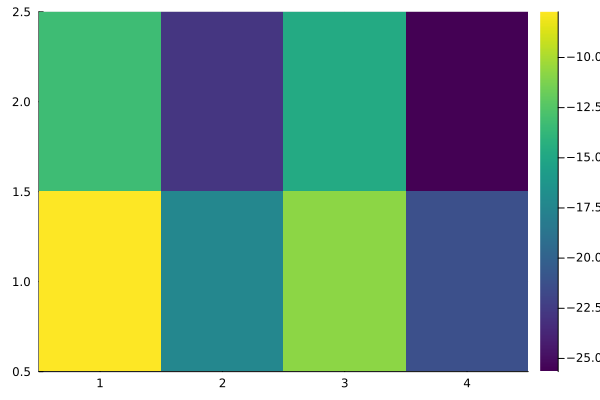

In [ ]:
using Plots

# Define your ranges
x = 1:4
y = 1:2

# Assuming En is a 3D array with dimensions matching the ranges of x and y
En=reshape(En,4,2,1)  # Example definition, replace with your actual data

# Create the z matrix by extracting the required slice from En
z = [En[xi, yi, 1] for xi in x, yi in y]

# Create the heatmap
contour!(x, y, z, color=:blue)
heatmap(x, y, z, color=:viridis)

In [ ]:
Energy

1-element Vector{Float64}:
 -25.6559124189716

In [ ]:
function ncon(
  tensor_list,
  connect_list_in;
  con_order = [],
  check_network = true,
)

  # copy original list to avoid destroying
  connect_list = deepcopy(connect_list_in)

  # put inputs into an array if necessary
  if (tensor_list[1] isa Real) | (tensor_list[1] isa Complex)
    tensor_list = Any[tensor_list]
  end
  if !(connect_list[1] isa Array)
    connect_list = Any[connect_list]
  end

  # generate contraction order if necessary
  flat_connect = vcat(connect_list...)
  if isempty(con_order)
    con_order = sort(unique(flat_connect[flat_connect.>0]))
  end

  # check inputs if enabled
  if check_network
    dims_list = Array{Any,1}(undef, length(tensor_list))
    for ik = 1:length(tensor_list)
      dims_list[ik] = [size(tensor_list[ik])...]
    end
    ncon_check_inputs(connect_list, flat_connect, dims_list, con_order)
  end

  # do all partial traces
  for ip = 1:length(connect_list)
    num_cont = length(connect_list[ip]) - length(unique(connect_list[ip]))
    if num_cont > 0
      tensor_list[ip], connect_list[ip], cont_label =
        ncon_partial_trace(tensor_list[ip], connect_list[ip])
      con_order = setdiff(con_order, cont_label)
    end
  end

  # do all binary contractions
  while !isempty(con_order)
    # identify tensors to be contracted
    cont_ind = con_order[1];
    locs = [
      ele
      for
      ele in collect(1:length(connect_list)) if
      sum(connect_list[ele] .== cont_ind) > 0
    ]

    # do a binary contraction
    cont_many = intersect(connect_list[locs[1]], connect_list[locs[2]])
    A_cont = [findfirst(connect_list[locs[1]] .== x) for x in cont_many]
    B_cont = [findfirst(connect_list[locs[2]] .== x) for x in cont_many]
    A_free = deleteat!(collect(1:length(connect_list[locs[1]])), sort(A_cont))
    B_free = deleteat!(collect(1:length(connect_list[locs[2]])), sort(B_cont))
    push!(
      tensor_list,
      ncon_tensordot(
        tensor_list[locs[1]],
        tensor_list[locs[2]],
        A_cont,
        B_cont,
      ),
    )
    push!(
      connect_list,
      vcat(connect_list[locs[1]][A_free], connect_list[locs[2]][B_free]),
    )

    # remove contracted tensors from list and update con_order
    deleteat!(connect_list, locs)
    deleteat!(tensor_list, locs)
    con_order = setdiff(con_order, cont_many)
  end

  # do all outer products
  while length(tensor_list) > 1
    s1 = size(tensor_list[end-1])
    s2 = size(tensor_list[end])
    tensor_list[end-1] = reshape(
      reshape(tensor_list[end-1], prod(s1)) *
      reshape(tensor_list[end], 1, prod(s2)),
      (s1..., s2...),
    )
    connect_list[end-1] = vcat(connect_list[end-1], connect_list[end])
    deleteat!(connect_list, length(connect_list))
    deleteat!(tensor_list, length(tensor_list))
  end

  # do final permutation
  if length(connect_list[1]) > 0
    return permutedims(tensor_list[1], sortperm(connect_list[1], by = abs))
  else
    return tensor_list[1][1]
  end
end

"""
ncon_tensordot: contracts a pair of tensors via matrix multiplication,
similar to the Numpy function of the same name
"""
function ncon_tensordot(A, B, A_cont, B_cont)

  A_free = deleteat!(collect(1:ndims(A)), sort(A_cont))
  B_free = deleteat!(collect(1:ndims(B)), sort(B_cont))
  A_perm = vcat(A_free, A_cont)
  B_perm = vcat(B_cont, B_free)

  return reshape(
    reshape(
      permutedims(A, A_perm),
      prod(size(A)[A_free]),
      prod(size(A)[A_cont]),
    ) * reshape(
      permutedims(B, B_perm),
      prod(size(B)[B_cont]),
      prod(size(B)[B_free]),
    ),
    (size(A)[A_free]..., size(B)[B_free]...),
  )
end

"""
ncon_partial_trace: partial trace on tensor A over repeated labels in A_label
"""
function ncon_partial_trace(A, A_label)

  num_cont = length(A_label) - length(unique(A_label))
  if num_cont > 0
    dup_list = []
    for ele in unique(A_label)
      if sum(A_label .== ele) > 1
        dup_list = vcat(dup_list, findall(A_label .== ele))
      end
    end

    cont_ind =
      reshape(permutedims(reshape(dup_list, 2, num_cont), [2, 1]), 2 * num_cont)
    free_ind = deleteat!(collect(1:length(A_label)), sort(dup_list))
    cont_dim = prod(size(A)[cont_ind[1:num_cont]])
    free_dim = size(A)[free_ind]

    cont_label = unique(A_label[cont_ind])
    B = zeros(prod(free_dim))
    perm_tot = [free_ind; cont_ind]

    A_dims = size(A)
    A = reshape(
      permutedims(reshape(A[:], A_dims), vcat(free_ind, cont_ind)),
      prod(free_dim),
      cont_dim,
      cont_dim,
    )
    for ip = 1:cont_dim
      B = B + A[:, ip, ip]
    end

    return reshape(B, free_dim), deleteat!(A_label, sort(cont_ind)), cont_label
  else
    return A, A_label
  end
end

"""
ncon_check_inputs: check consistency of input tensor network
"""
function ncon_check_inputs(connect_list, flat_connect, dims_list, con_order)

  pos_ind = flat_connect[flat_connect.>0]
  neg_ind = flat_connect[flat_connect.<0]

  # check that lengths of lists match
  if length(dims_list) != length(connect_list)
    e_str0 = "NCON error: $(length(dims_list)) tensors given ";
    error(e_str0,"but $(length(connect_list)) index sublists given")
  end

  # check that tensors have the right number of indices
  for ik = 1:length(dims_list)
    if length(dims_list[ik]) != length(connect_list[ik])
      e_str0 = "number of indices does not match number of labels on tensor ";
      e_str1 = "$(ik): $(length(dims_list[ik]))-indices "
      error(e_str0,e_str1,"versus $(length(connect_list[ik]))-labels")
    end
  end

  # check that contraction order is valid
  if !(sort(con_order) == sort(unique(pos_ind)))
    error("NCON error: invalid contraction order")
  end

  # check that negative indices are valid
  for ind = -1:-1:-length(neg_ind)
    if sum(neg_ind .== ind) == 0
      error("NCON error: no index labelled $(ind)")
    elseif sum(neg_ind .== ind) > 1
      error("NCON error: more than one index labelled $(ind)")
    end
  end

  # check that positive indices are valid and contracted tensor dimensions match
  flat_dims = []
  for ele in dims_list
    flat_dims = vcat(flat_dims, ele)
  end
  for ind in unique(pos_ind)
    if sum(pos_ind .== ind) == 1
      error("NCON error: only one index labelled $(ind)")
    elseif sum(pos_ind .== ind) > 2
      error("NCON error: more than two indices labelled $(ind)")
    end
    cont_dims = flat_dims[flat_connect.==ind]
    if cont_dims[1] != cont_dims[2]
      e_str0 = "dimension mismatch on index labelled $(ind): "
      error(e_str0,"dim-$(cont_dims[1]) versus dim-$(cont_dims[2])")
    end
  end

  return true
end


ncon_check_inputs

In [ ]:
using Pkg
Pkg.add(["HTTP", "FileIO", "Images", "Flux"])


    Updating registry at `C:\Users\shikh\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\shikh\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\shikh\.julia\environments\v1.10\Manifest.toml`


In [ ]:
using HTTP, FileIO, Images, Flux

# Function to download image from URL
function download_image(url, save_path)
    open(save_path, "w") do file
        write(file, HTTP.get(url).body)
    end
end

# Download the image
url = "https://example.com/path/to/your/image.jpg"
save_path = "downloaded_image.jpg"
download_image(url, save_path)

# Load and process the image
img = load(save_path) |> Images.Gray # Convert to grayscale

# Convert image to tensor
tensor = Flux.unsqueeze(collect(channelview(img)), 3)

println("Image tensor shape: ", size(tensor))


LoadError: HTTP.ConnectError for url = `https://example.com/path/to/your/image.jpg`: DNSError: example.com, unknown node or service (EAI_NONAME)
Stacktrace:
 [1] [0m[1mgetalladdrinfo[22m[0m[1m([22m[90mhost[39m::[0mString[0m[1m)[22m
[90m   @[39m [32mSockets[39m [90mC:\Users\shikh\.julia\juliaup\julia-1.10.0+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Sockets\src\[39m[90m[4maddrinfo.jl:113[24m[39m
 [2] [0m[1mgetalladdrinfo[22m[0m[1m([22m[90mhost[39m::[0mString[0m[1m)[22m
[90m   @[39m [32mSockets[39m [90mC:\Users\shikh\.julia\juliaup\julia-1.10.0+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Sockets\src\[39m[90m[4maddrinfo.jl:122[24m[39m[90m [inlined][39m
 [3] [0m[1mgetconnection[22m[0m[1m([22m::[0mType[90m{Sockets.TCPSocket}[39m, [90mhost[39m::[0mSubString[90m{String}[39m, [90mport[39m::[0mString; [90mkeepalive[39m::[0mBool, [90mreadtimeout[39m::[0mInt64, [90mkw[39m::[0m@Kwargs[90m{require_ssl_verification::Bool, iofunction::Nothing, decompress::Nothing, verbose::Int64}[39m[0m[1m)[22m
[90m   @[39m [35mHTTP.Connections[39m [90mC:\Users\shikh\.julia\packages\HTTP\sJD5V\src\[39m[90m[4mConnections.jl:520[24m[39m
 [4] [0m[1mgetconnection[22m
[90m   @[39m [90mC:\Users\shikh\.julia\packages\HTTP\sJD5V\src\[39m[90m[4mConnections.jl:508[24m[39m[90m [inlined][39m
 [5] [0m[1mgetconnection[22m[0m[1m([22m::[0mType[90m{OpenSSL.SSLStream}[39m, [90mhost[39m::[0mSubString[90m{String}[39m, [90mport[39m::[0mSubString[90m{String}[39m; [90mkw[39m::[0m@Kwargs[90m{require_ssl_verification::Bool, keepalive::Bool, readtimeout::Int64, iofunction::Nothing, decompress::Nothing, verbose::Int64}[39m[0m[1m)[22m
[90m   @[39m [35mHTTP.Connections[39m [90mC:\Users\shikh\.julia\packages\HTTP\sJD5V\src\[39m[90m[4mConnections.jl:585[24m[39m
 [6] [0m[1mgetconnection[22m
[90m   @[39m [90mC:\Users\shikh\.julia\packages\HTTP\sJD5V\src\[39m[90m[4mConnections.jl:578[24m[39m[90m [inlined][39m
 [7] [0m[1m#10[22m
[90m   @[39m [90mC:\Users\shikh\.julia\packages\HTTP\sJD5V\src\[39m[90m[4mConnections.jl:467[24m[39m[90m [inlined][39m
 [8] [0m[1mmacro expansion[22m
[90m   @[39m [90mC:\Users\shikh\.julia\packages\ConcurrentUtilities\QOkoO\src\[39m[90m[4mtry_with_timeout.jl:82[24m[39m[90m [inlined][39m
 [9] [0m[1m(::ConcurrentUtilities.var"#2#4"{Any, Timer, ConcurrentUtilities.TimedOut{Any}, Channel{Any}, HTTP.Connections.var"#10#13"{OpenSSL.SSLStream, Bool, Bool, @Kwargs{readtimeout::Int64, iofunction::Nothing, decompress::Nothing, verbose::Int64}, SubString{String}, SubString{String}}})[22m[0m[1m([22m[0m[1m)[22m
[90m   @[39m [33mConcurrentUtilities[39m [90mC:\Users\shikh\.julia\packages\ConcurrentUtilities\QOkoO\src\[39m[90m[4mConcurrentUtilities.jl:9[24m[39m

# **finite DMRG**

In [ ]:
function doDMRG_MPO(A,ML,M,MR,chi; numsweeps = 10, dispon = 2, updateon = true, maxit = 2, krydim = 4)

    # left-to-right 'warmup', put MPS in right orthogonal form
    chid = size(M,3); #local dimension
    Nsites = length(A);
    L = Array{Any,1}(undef,Nsites); L[1] = ML;
    R = Array{Any,1}(undef,Nsites); R[Nsites] = MR;
    for p = 1:Nsites-1
        chil = size(A[p],1); chir = size(A[p],3);
        F = svd(reshape(A[p],chil*chid,chir));
        A[p] = reshape(F.U,chil,chid,chir);
        A[p+1] = ncon(Any[diagm(0 => F.S)*F.Vt,A[p+1]],Any[[-1,1],[1,-2,-3]])/norm(F.S);
        L[p+1] = ncon(Any[L[p],M,A[p],conj(A[p])],Any[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]]);
    end
    chil = size(A[Nsites],1); chir = size(A[Nsites],3);
    F = svd(reshape(A[Nsites],chil*chid,chir));
    A[Nsites] = reshape(F.U,chil,chid,chir);
    sWeight = Array{Any,1}(undef,Nsites+1);
    sWeight[Nsites+1] = (diagm(0 => F.S)*F.Vt) ./norm(F.S);

    Ekeep = zeros(0);
    B = Array{Any,1}(undef,Nsites);
    for k = 1:numsweeps+1

        if k == numsweeps+1
            # final sweep is only for orthogonalization (disable updates)
            updateon = false;
            dispon = 0;
        end

        # Optimization sweep: right-to-left
        for p = Nsites-1:-1:1

            # two-site update
            chil = size(A[p],1); chir = size(A[p+1],3);
            psiGround = reshape(ncon(Any[A[p],A[p+1],sWeight[p+2]],Any[[-1,-2,1],[1,-3,2],[2,-4]]),chil*chid^2*chir)
            if updateon
                psiGround, Entemp = eigLanczos(psiGround,doApplyMPO,(L[p],M,M,R[p+1]); maxit = maxit, krydim = krydim);
                push!(Ekeep,Entemp)
            end
            F = svd(reshape(psiGround,chil*chid,chid*chir));
            chitemp = min(length(F.S),chi)
            A[p] = reshape(F.U[:,1:chitemp],chil,chid,chitemp);
            sWeight[p+1] = diagm(0 => (F.S[1:chitemp]./sqrt(sum(F.S[1:chitemp].^2))));
            B[p+1] = reshape(F.Vt[1:chitemp,:],chitemp,chid,chir);

            # new block Hamiltonian
            R[p] = ncon(Any[M,R[p+1],B[p+1],conj(B[p+1])],Any[[-1,2,3,5],[2,1,4],[-3,5,4],[-2,3,1]]);

            # display energy
            if dispon == 2
                @printf "Sweep: %d of %d, Loc: %d, Energy: %f\n" k numsweeps p Ekeep[end]
            end
        end

        # left boundary tensor
        chil = size(A[1],1); chir = size(A[1],3);
        F = svd(reshape(ncon(Any[A[1],sWeight[2]],Any[[-1,-2,1],[1,-3]]),chil,chid*chir));
        B[1] = reshape(F.Vt,chil,chid,chir);
        sWeight[1] = F.U*diagm(0 => F.S)./sqrt(sum(F.S .^2));

        # Optimization sweep: left-to-right
        for p = 1:Nsites-1

            # two-site update
            chil = size(B[p],1); chir = size(B[p+1],3);
            psiGround = reshape(ncon(Any[sWeight[p],B[p],B[p+1]],Any[[-1,1],[1,-2,2],[2,-3,-4]]),chil*chid^2*chir);
            if updateon
                psiGround, Entemp = eigLanczos(psiGround,doApplyMPO,(L[p],M,M,R[p+1]); maxit = maxit, krydim = krydim);
                push!(Ekeep,Entemp)
            end
            F = svd(reshape(psiGround,chil*chid,chid*chir));
            chitemp = min(length(F.S),chi)
            A[p] = reshape(F.U[:,1:chitemp],chil,chid,chitemp);
            sWeight[p+1] = diagm(0 => (F.S[1:chitemp]./sqrt(sum(F.S[1:chitemp].^2))));
            B[p+1] = reshape(F.Vt[1:chitemp,:],chitemp,chid,chir);

            # new block Hamiltonian
            L[p+1] = ncon(Any[L[p],M,A[p],conj(A[p])],Any[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]]);

            # display energy
            if dispon == 2
                @printf "Sweep: %d of %d, Loc: %d, Energy: %f\n" k numsweeps p Ekeep[end]
            end
        end

        # right boundary tensor
        chil = size(B[Nsites],1); chir = size(B[Nsites],3);
        F = svd(reshape(ncon(Any[B[Nsites],sWeight[Nsites]],Any[[1,-2,-3],[-1,1]]),chil*chid,chir));
        A[Nsites] = reshape(F.U,chil,chid,chir);
        sWeight[Nsites+1] = (diagm(0 => F.S)./sqrt(sum(F.S .^2)))*F.Vt;

        if dispon == 1
            @printf "Sweep: %d of %d, Energy: %f, Bond dim: %d\n" k numsweeps Ekeep[end] chi
        end
    end

    return Ekeep, A, sWeight, B
end

function doApplyMPO(psi,L,M1,M2,R)

    return reshape(ncon(Any[reshape(psi,size(L,3),size(M1,4),size(M2,4),size(R,3)),L,M1,M2,R],
        Any[[1,3,5,7],[2,-1,1],[2,4,-2,3],[4,6,-3,5],[6,-4,7]]),size(L,3)*size(M1,4)*size(M2,4)*size(R,3));
end


function eigLanczos(psivec,linFunct,functArgs; maxit = 2, krydim = 4)

    if norm(psivec) == 0
        psivec = rand(length(psivec),1);
    end
    psi = zeros(length(psivec),krydim+1);
    A = zeros(krydim,krydim);
    dval = 0;
    for k = 1:maxit

        psi[:,1] = psivec/max(norm(psivec),1e-16);
        for p = 2:krydim+1
            psi[:,p] = linFunct(psi[:,p-1],functArgs...);
            for g = 1:1:p-1
                A[p-1,g] = dot(psi[:,p],psi[:,g]);
                A[g,p-1] = conj(A[p-1,g]);
            end
            for g = 1:1:p-1
                psi[:,p] = psi[:,p] - dot(psi[:,g],psi[:,p])*psi[:,g];
                psi[:,p] = psi[:,p]/max(norm(psi[:,p]),1e-16);
            end
        end

        G = eigen(0.5*(A+A'));
        dval, xloc = findmin(G.values);
        psivec = psi[:,1:krydim]*G.vectors[:,xloc[1]];
    end
    psivec = psivec/norm(psivec);

    return psivec, dval
end

eigLanczos (generic function with 1 method)

**initialization script**
#**(Hamiltonian for 1D spin chain as an MPO)**

In [ ]:
#developing for lanczos
rand(1,chid,min(chi,chid))

1×2×2 Array{Float64, 3}:
[:, :, 1] =
 0.830752  0.630485

[:, :, 2] =
 0.283848  0.232277

In [ ]:
En1

LoadError: UndefVarError: `En1` not defined

In [ ]:
chi = 16; # maximum bond dimension
Nsites = 50; # number of lattice sites

OPTS_numsweeps = 4; # number of DMRG sweeps
OPTS_dispon = 2; # level of output display
OPTS_updateon = true; # update MPS tensors
OPTS_maxit = 2; # iterations of Lanczos method
OPTS_krydim = 4; # dimension of Krylov subspace

#### Define Hamiltonian MPO (quantum TFIM model)
chid = 2;
sP = sqrt(1)*[0 0;1 0]; sM = sqrt(1)*[0 1;0 0];
sX = [0 1; 1 0]; sY = [0 -im; im 0];
sZ = [1 0; 0 -1]; sI = [1 0; 0 1];
M = zeros(4,4,chid,chid);
M[1,1,:,:] = sI; M[4,4,:,:] = sI;
M[1,2,:,:] = sM; M[2,4,:,:] = sP;
M[1,3,:,:] = sP; M[3,4,:,:] = sM;
ML = reshape([1;0;0;0],4,1,1); #left MPO boundary
MR = reshape([0;0;0;1],4,1,1); #right MPO boundary

#### Initialize MPS tensors
A = Array{Any,1}(undef,Nsites); A[1] = rand(1,chid,min(chi,chid));
for k = 2:Nsites
    A[k] = rand(size(A[k-1],3),chid,min(min(chi,size(A[k-1],3)*chid),chid^(Nsites-k)));
end
H = diagm(1 => ones(Nsites-1)) + diagm(-1 => ones(Nsites-1));
D = eigen(0.5*(H+H'));
EnExact = 2*sum(D.values[D.values .< 0]);

# En1, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);
# Em=reshape(En1,1,length(En1))
E=[]
# for p in 1:length(Em)

# end
chi = 20;
En2, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);

chi = 22;
En3, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);
chi = 24;
En4, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);
chi = 28;
En5, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);
chi = 30;
En6, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);
chi = 32;
En7, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);

#### Compare with exact results (computed from free fermions)
H = diagm(1 => ones(Nsites-1)) + diagm(-1 => ones(Nsites-1));
D = eigen(0.5*(H+H'));
EnExact = 2*sum(D.values[D.values .< 0]);
plot(1:length(En1),log10.(En1 .-EnExact),xlabel = "Update Step",
    ylabel = "-log10(Ground Energy Error)", label = "chi = 16", title = "DMRG for TFIM model");
# display(plot!(1:length(En2),log10.(En2 .-EnExact), label = "chi = 32"));

Sweep: 1 of 4, Loc: 49, Energy: 19.805947
Sweep: 1 of 4, Loc: 48, Energy: 18.149584
Sweep: 1 of 4, Loc: 47, Energy: 15.387396
Sweep: 1 of 4, Loc: 46, Energy: 14.492903
Sweep: 1 of 4, Loc: 45, Energy: 13.330270
Sweep: 1 of 4, Loc: 44, Energy: 12.048615
Sweep: 1 of 4, Loc: 43, Energy: 10.983726
Sweep: 1 of 4, Loc: 42, Energy: 10.168974
Sweep: 1 of 4, Loc: 41, Energy: 8.944705
Sweep: 1 of 4, Loc: 40, Energy: 7.540641
Sweep: 1 of 4, Loc: 39, Energy: 6.480092
Sweep: 1 of 4, Loc: 38, Energy: 5.595568
Sweep: 1 of 4, Loc: 37, Energy: 4.623753
Sweep: 1 of 4, Loc: 36, Energy: 3.309615
Sweep: 1 of 4, Loc: 35, Energy: 2.290853
Sweep: 1 of 4, Loc: 34, Energy: 1.202751
Sweep: 1 of 4, Loc: 33, Energy: -0.233286
Sweep: 1 of 4, Loc: 32, Energy: -1.375700
Sweep: 1 of 4, Loc: 31, Energy: -2.342279
Sweep: 1 of 4, Loc: 30, Energy: -3.169761
Sweep: 1 of 4, Loc: 29, Energy: -4.648134
Sweep: 1 of 4, Loc: 28, Energy: -5.651636
Sweep: 1 of 4, Loc: 27, Energy: -7.161059
Sweep: 1 of 4, Loc: 26, Energy: -8.270236


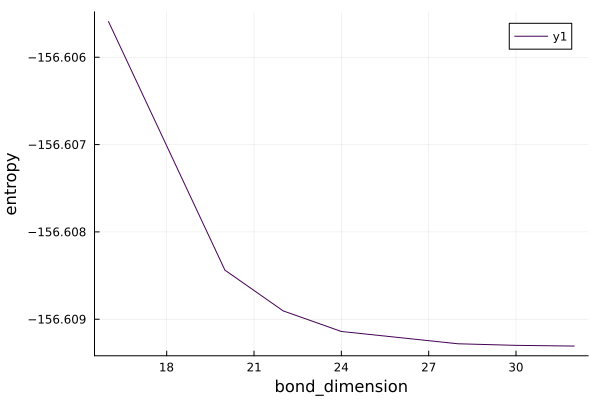

In [ ]:
n = 7
E = Array{Float64}(undef, n)
Em=reshape(En1,1,length(En1))
Em=reshape(En1,1,length(En1))
for p in 1:length(Em)
    E[1]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
Em=reshape(En2,1,length(En2))
for p in 1:length(Em)
    E[2]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
Em=reshape(En3,1,length(En3))
for p in 1:length(Em)
    E[3]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
Em=reshape(En4,1,length(En4))
for p in 1:length(Em)
    E[4]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
Em=reshape(En5,1,length(En5))
for p in 1:length(Em)
    E[5]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
Em=reshape(En6,1,length(En6))
for p in 1:length(Em)
    E[6]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
Em=reshape(En7,1,length(En7))
for p in 1:length(Em)
    E[7]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
bon_dim=[16,20,22,24,28,30,32]
plot(bon_dim,E.*-1,xlabel="bond_dimension",ylabel="entropy",colormap=:viridis)

In [ ]:
Em=reshape(En1,1,length(En1))
# E=Array{Any,1}(undef,length(Em))
for p in 1:length(Em)
    E=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)))
end
E
# plot(1:length(En1),E,xlabel = "Update Step",
    # ylabel = "entropy", label = "chi = 16", title = "DMRG for XX model");

156.60549446076953

#**changed hamiltonian**

In [ ]:
function DMRG(A,ML,M,MR,chi; numsweeps = 10, dispon = 2, updateon = true, maxit = 2, krydim = 4)
    chid=size(M,3);#local dimension
    Nsites=length(A);
    L=Array{Any,1}(undef,Nsites);L[1]=ML;
    R=Array{Any,1}(undef,Nsites);R[Nsites]=MR;
    for p in 1:Nsites-1#left to right warmup,putting MPS in right oethogonal form
        chil=size(A[p],1);chir=size(A[p],3);
        F=svd(reshape(A[p],chil*chid,chir));
        A[p]=reshape(F.U,chil,chid,chir);
        A[p+1]=netcon(Any[diagm(0=>F.S)*F.Vt,A[p+1]],Any[[-1,1],[1,-2,-3]])/norm(F.S);
        L[p+1]=netcon(Any[L[p],M,A[p],conj(A[p])],Any[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]]);
    end
    chil=size(A[Nsites],1);chir=size(A[Nsites],3);
    F=svd(reshape(A[Nsites],chil*chid,chir));
    A[Nsites]=reshape(F.U,chil,chid,chir);
    sWeight=Array{Any,1}(undef,Nsites+1);
    sWeight[Nsites+1]=(diagm(0=>F.S)*F.Vt)./norm(F.S);
    Ekeep=zeros(0)
    B=Array{Any,1}(undef,Nsites);
    for k in 1:numsweeps+1
        if k==numsweeps+1
            updateon=false; #terminating the sweeping process
            dispon=0;
        end
        #optimizing sweeps from right to left
        for p in Nsites-1:-1:1
            chil=size(A[p],1);chir=size(A[p+1],3);
            psiground=reshape(netcon(Any[A[p],A[p+1],sWeight[p+2]],Any[[-1,-2,1],[1,-3,2],[2,-4]]),chil*chid^2*chir);
            if updateon
                psiground,Entemp=eigLanczos(psiground,applyMPO,(L[p],M,M,R[p+1]);maxit=maxit,krydim=krydim);
                push!(Ekeep,Entemp)
            end
            F=svd(reshape(psiground,chil*chid,chid*chir));
            chitemp=min(length(F.S),chi)
            A[p]=reshape(F.U[:,1:chitemp],chil,chid,chitemp);
            sWeight[p+1]=diagm(0=>(F.S[1:chitemp]./sqrt(sum(F.S[1:chitemp].^2))));
            B[p+1]=reshape(F.Vt[1:chitemp,:],chitemp,chid,chir);
            #new block hamiltonian
            R[p]=netcon(Any[M,R[p+1],B[p+1],conj(B[p+1])],Any[[-1,2,3,5],[2,1,4],[-3,5,4],[-2,3,1]])
            #displaying the energy
            if dispon == 2
                @printf "Sweep: %d of %d, Loc: %d, Energy: %f\n" k numsweeps p Ekeep[end]
            end
        end
        #left boundary tensor action
        chil=size(A[1],1);chir=size(A[1],3);
        F=svd(reshape(netcon(Any[A[1],sWeight[2]],Any[[-1,-2,1],[1,-3]]),chil,chid*chir));
        B[1]=reshape(F.Vt,chil,chid,chir);
        sWeight[1]=F.U*diagm(0=>F.S)./sqrt(sum(F.S.^2));
        #optimization sweeps from  left to right
        for p in 1:Nsites-1
            chil=size(B[p],1);chir=size(B[p+1],3);
            psiground=reshape(netcon(Any[sWeight[p],B[p],B[p+1]],Any[[-1,1],[1,-2,2],[2,-3,-4]]),chil*chid^2*chir);
            if updateon
                psiground,Entemp=eigLanczos(psiground,applyMPO,(L[p],M,M,R[p+1]);maxit=maxit,krydim=krydim);
                push!(Ekeep,Entemp)
            end
            F=svd(reshape(psiground,chil*chid,chid*chir));
            chitemp=min(chi,length(F.S));
            A[p]=reshape(F.U[:,1:chitemp],chil,chid,chitemp);
            sWeight[p+1]=diagm(0=>(F.S[1:chitemp]./sqrt(sum(F.S[1:chitemp].^2))));
            B[p+1]=reshape(F.Vt[1:chitemp,:],chitemp,chid,chir);
            #new block hamiltonian
            L[p+1]=netcon(Any[L[p],M,A[p],conj(A[p])],Any[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]]);
            if dispon==2
                @printf "Sweep: %d of %d ,Loc : %d, Energy: %f\n" k numsweeps p Ekeep[end]
            end
        end
        # right boundary tensor
        chil = size(B[Nsites],1); chir = size(B[Nsites],3);
        F = svd(reshape(netcon(Any[B[Nsites],sWeight[Nsites]],Any[[1,-2,-3],[-1,1]]),chil*chid,chir));
        A[Nsites] = reshape(F.U,chil,chid,chir);
        sWeight[Nsites+1] = (diagm(0 => F.S)./sqrt(sum(F.S .^2)))*F.Vt;
        if dispon == 1
            @printf "Sweep: %d of %d, Energy: %f, Bond dim: %d\n" k numsweeps Ekeep[end] chi
        end
    end
    return Ekeep,A,sWeight,B
end
function applyMPO(psi,L,M1,M2,R)
    return reshape(netcon(Any[reshape(psi,size(L,3),size(M1,4),size(M2,4),size(R,3)),L,M1,M2,R], Any[[1,3,5,7],[2,-1,1],[2,4,-2,3],[4,6,-3,5],[6,-4,7]]),size(L,3)*size(M1,4)*size(M2,4)*size(R,3));
end
function eigLanczos(psivec,linFunct,functArgs;maxit=2,krydim=4)
    if norm(psivec)==0
        psivec=rand(length(psivec),1);
    end
        psi=zeros(length(psivec),krydim+1);
        A=zeros(krydim,krydim);
        dval=0;
        for k in 1:maxit
        psi[:,1]=psivec/max(norm(psivec),1e-16);
        for p in 2:krydim+1
            psi[:,p]=linFunct(psi[:,p-1],functArgs...);
            for g in 1:1:p-1
                A[p-1,g]=dot(psi[:,p],psi[:,g]);
                A[g,p-1]=conj(A[p-1,g]);
            end
            for g in 1:1:p-1
                psi[:,p]=psi[:,p]-dot(psi[:,g],psi[:,p])*psi[:,g];
                psi[:,p]=psi[:,p]/max(norm(psi[:,p]),1e-16);
            end
        end
            G=eigen(0.5*(A+A'));
            dval,xloc=findmin(G.values);
            psivec=psi[:,1:krydim]*G.vectors[:,xloc[1]];
        end
        psivec=psivec/norm(psivec);
    return psivec,dval
end

eigLanczos (generic function with 1 method)

In [ ]:
chi = 16; # maximum bond dimension
Nsites = 50; # number of lattice sites

OPTS_numsweeps = 4; # number of DMRG sweeps
OPTS_dispon = 2; # level of output display
OPTS_updateon = true; # update MPS tensors
OPTS_maxit = 2; # iterations of Lanczos method
OPTS_krydim = 4; # dimension of Krylov subspace

#### Define Hamiltonian MPO (quantum TFIM model)
chid = 2;
sP = sqrt(1)*[0 0;1 0]; sM = sqrt(1)*[0 1;0 0];
sX = [0 1; 1 0]; sY = [0 -im; im 0];
sZ = [1 0; 0 -1]; sI = [1 0; 0 1];
M = zeros(4,4,chid,chid);
M[1,1,:,:] = sI; M[4,4,:,:] = sI;
M[1,2,:,:] = sZ; M[2,4,:,:] = sZ;
M[1,4,:,:] = sX; M[3,4,:,:] = sZ;
ML = reshape([1;0;0;0],4,1,1); #left MPO boundary
MR = reshape([0;0;0;1],4,1,1); #right MPO boundary

In [ ]:
#initializing the MPS
A = Array{Any,1}(undef,Nsites); A[1] = rand(1,chid,min(chi,chid));
for k = 2:Nsites
    A[k] = rand(size(A[k-1],3),chid,min(min(chi,size(A[k-1],3)*chid),chid^(Nsites-k)));
end
chi = 16;
En1, A, sWeight, B = DMRG(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);


Sweep: 1 of 4, Loc: 49, Energy: 41.121185
Sweep: 1 of 4, Loc: 48, Energy: 36.656666
Sweep: 1 of 4, Loc: 47, Energy: 33.324343
Sweep: 1 of 4, Loc: 46, Energy: 27.916399
Sweep: 1 of 4, Loc: 45, Energy: 25.890099
Sweep: 1 of 4, Loc: 44, Energy: 23.169018
Sweep: 1 of 4, Loc: 43, Energy: 21.524457
Sweep: 1 of 4, Loc: 42, Energy: 18.624682
Sweep: 1 of 4, Loc: 41, Energy: 16.832102
Sweep: 1 of 4, Loc: 40, Energy: 14.997733
Sweep: 1 of 4, Loc: 39, Energy: 12.408188
Sweep: 1 of 4, Loc: 38, Energy: 10.018930
Sweep: 1 of 4, Loc: 37, Energy: 7.585458
Sweep: 1 of 4, Loc: 36, Energy: 5.463684
Sweep: 1 of 4, Loc: 35, Energy: 3.826307
Sweep: 1 of 4, Loc: 34, Energy: 0.687788
Sweep: 1 of 4, Loc: 33, Energy: -1.265951
Sweep: 1 of 4, Loc: 32, Energy: -4.013814
Sweep: 1 of 4, Loc: 31, Energy: -5.948856
Sweep: 1 of 4, Loc: 30, Energy: -8.312416
Sweep: 1 of 4, Loc: 29, Energy: -10.719968
Sweep: 1 of 4, Loc: 28, Energy: -13.134623
Sweep: 1 of 4, Loc: 27, Energy: -14.914338
Sweep: 1 of 4, Loc: 26, Energy: -17

In [ ]:
chi = 20;
En2, A, sWeight, B = DMRG(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);

chi = 22;
En3, A, sWeight, B = DMRG(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);
chi = 24;
En4, A, sWeight, B = DMRG(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);
chi = 28;
En5, A, sWeight, B = DMRG(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);
chi = 30;
En6, A, sWeight, B = DMRG(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);
chi = 32;
En7, A, sWeight, B = DMRG(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);
chi = 34;
En8, A, sWeight, B = DMRG(A,ML,M,MR,chi; numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim);


Sweep: 1 of 4, Loc: 49, Energy: -63.301189
Sweep: 1 of 4, Loc: 48, Energy: -63.301189
Sweep: 1 of 4, Loc: 47, Energy: -63.301189
Sweep: 1 of 4, Loc: 46, Energy: -63.301189
Sweep: 1 of 4, Loc: 45, Energy: -63.301189
Sweep: 1 of 4, Loc: 44, Energy: -63.301189
Sweep: 1 of 4, Loc: 43, Energy: -63.301189
Sweep: 1 of 4, Loc: 42, Energy: -63.301189
Sweep: 1 of 4, Loc: 41, Energy: -63.301189
Sweep: 1 of 4, Loc: 40, Energy: -63.301189
Sweep: 1 of 4, Loc: 39, Energy: -63.301189
Sweep: 1 of 4, Loc: 38, Energy: -63.301189
Sweep: 1 of 4, Loc: 37, Energy: -63.301189
Sweep: 1 of 4, Loc: 36, Energy: -63.301189
Sweep: 1 of 4, Loc: 35, Energy: -63.301189
Sweep: 1 of 4, Loc: 34, Energy: -63.301189
Sweep: 1 of 4, Loc: 33, Energy: -63.301189
Sweep: 1 of 4, Loc: 32, Energy: -63.301189
Sweep: 1 of 4, Loc: 31, Energy: -63.301189
Sweep: 1 of 4, Loc: 30, Energy: -63.301189
Sweep: 1 of 4, Loc: 29, Energy: -63.301189
Sweep: 1 of 4, Loc: 28, Energy: -63.301189
Sweep: 1 of 4, Loc: 27, Energy: -63.301189
Sweep: 1 of

In [ ]:
n = 8
E = Array{Float64}(undef, n)
Em=reshape(En1,1,length(En1))
Em=reshape(En1,1,length(En1))
for p in 1:length(Em)
    E[1]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
Em=reshape(En2,1,length(En2))
for p in 1:length(Em)
    E[2]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
Em=reshape(En3,1,length(En3))
for p in 1:length(Em)
    E[3]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
Em=reshape(En4,1,length(En4))
for p in 1:length(Em)
    E[4]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
Em=reshape(En5,1,length(En5))
for p in 1:length(Em)
    E[5]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
Em=reshape(En6,1,length(En6))
for p in 1:length(Em)
    E[6]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
Em=reshape(En7,1,length(En7))
for p in 1:length(Em)
    E[7]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
Em=reshape(En8,1,length(En8))
for p in 1:length(Em)
    E[8]=sum(sqrt(Em[p]^2)log2(sqrt(Em[p]^2)));
end
bon_dim=[16,20,22,24,28,30,32,34]
size(E)
# plot(bon_dim,E.*-1,xlabel="bond_dimension",ylabel="entropy",colormap=:viridis)

(8,)

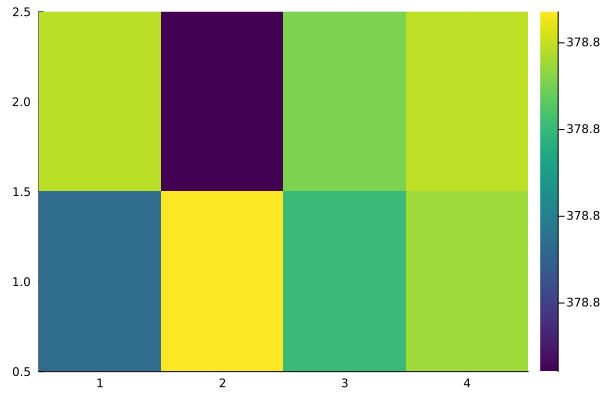

In [ ]:
using Plots

# Define your ranges
x = 1:4
y = 1:2

# Assuming En is a 3D array with dimensions matching the ranges of x and y
E=reshape(E,4,2,1)  # Example definition, replace with your actual data

# Create the z matrix by extracting the required slice from En
z = [E[xi, yi, 1] for xi in x, yi in y]

# Create the heatmap
heatmap(x, y, z, color=:viridis)

# **TEBD**

In [ ]:
Nsites=4;
chid=2;
chi=10;
M_ster=Array{Any,1}(undef,Nsites);
A = Array{Any,1}(undef,Nsites); A[1] = rand(1,chid,min(chi,chid));
for k = 2:Nsites
    A[k] = rand(size(A[k-1],3),chid,min(min(chi,size(A[k-1],3)*chid),chid^(Nsites-k)));
end
size(A);

M_sterS=Array{Any,1}(undef,Nsites);
d=2;
A=rand(chi,d,chi);
B=rand(chi,d,chi);
M_ster[1]=A;
nt=ones(chi)./sqrt(chi);#setting trivial weights

for p in 1:length(M_ster)
    M_ster[p]=rand(chi,d,chi)
end
for p in 1:length(M_ster)
    M_sterS[p]=diagm(0=>nt)
end
label_ls=Any[[11,13],[12,14],[13,15,16],[14,15,17],[16,18],[17,19],[18,20,-1],[19,20,-2]]
labels=Any[[1,2],[1,3],[2,4],[3,5,6],[4,5,7],[6,8],[7,9],[8,10,11],[9,10,12]]
labels_n=Any[[1,3],[2,4],[3,5,6],[4,5,7],[6,8],[7,9],[8,10,11],[9,10,12]]
j=10

10

# **Setting up N(50) site MPS(random)**

In [ ]:
Nsites = 50
chi = 10
M_ster=Array{Any,1}(undef,Nsites);
for p in 1:length(M_ster)
    M_ster[p]=rand(chi,d,chi)
end
M_sterS = Array{Any,1}(undef, Nsites)
nt = ones(chi) ./ sqrt(chi)
for p in 1:length(M_sterS)
    M_sterS[p] = diagm(0=>nt)
end
tensor = Array{Any,1}(undef, 4 * Nsites)
for o in 1:4:length(tensor)
    tensor[o] = M_sterS[o ÷ 4 + 1]
    tensor[o + 1] = M_sterS[o ÷ 4 + 1]
end
for o in 3:4:length(tensor)
    tensor[o] = M_ster[o ÷ 4 + 1]
    tensor[o + 1] = conj(M_ster[o ÷ 4 + 1])
end
length(tensor)

200

In [ ]:
size(tensor[3])
# diagm(0=>M_sterS[2])

(10, 2, 10)

In [ ]:
#definin new labeling indices for network contraction
E_nm=Nsites/2
# labels = Any[[1,2],[1,3],[2,4],[3,5,6],[4,5,7],[6,8],[7,9],[8,10,11],[9,10,12]]
labels = Any[[1,2],[3,1],[5,2],[6,4,3],[7,4,5],[8,6],[10,7],[11,9,8],[12,9,10]];
labels_n=Any[[3,1],[5,2],[6,4,3],[7,4,5],[8,6],[10,7],[11,9,8],[12,9,10]];
labels_pr = Any[[3,1],[5,2],[6,4,3],[7,4,5],[8,6],[10,7],[-1,9,8],[-2,9,10]];
for x in 10:10:(E_nm-2)*10
    for i in 1:8
        new_label = labels_n[i] .+ x
        push!(labels, new_label)  # Append new labels to the existing array
    end
end
# labels_pr = Any[[1,3],[2,4],[3,5,6],[4,5,7],[6,8],[7,9],[8,10,-1],[9,10,-2]]
for i in 1:length(labels_pr)
    new_label=labels_pr[i].+10*(E_nm-1)
    push!(labels,new_label)
end
labels[end-1][end-2]=-1
labels[end][end-2]=-2
labels

201-element Vector{Any}:
 [1, 2]
 [3, 1]
 [5, 2]
 [6, 4, 3]
 [7, 4, 5]
 [8, 6]
 [10, 7]
 [11, 9, 8]
 [12, 9, 10]
 [13.0, 11.0]
 [15.0, 12.0]
 [16.0, 14.0, 13.0]
 [17.0, 14.0, 15.0]
 ⋮
 [238.0, 236.0]
 [240.0, 237.0]
 [241.0, 239.0, 238.0]
 [242.0, 239.0, 240.0]
 [243.0, 241.0]
 [245.0, 242.0]
 [246.0, 244.0, 243.0]
 [247.0, 244.0, 245.0]
 [248.0, 246.0]
 [250.0, 247.0]
 [-1.0, 249.0, 248.0]
 [-2.0, 249.0, 250.0]

In [ ]:
# Set environment tensor to develop semi-infinite networks to enable contraction
# by choosing random tensor and using transfer operation
sigBA = rand(chi, chi)
tol = 1e-10  # Convergence tolerance

for k in 1:1000
    global sigBA, tensor, labels, tol
    sigBA_new = netcon(Any[sigBA, tensor...], labels)  # Contract transfer operation
    sigBA_new = sigBA_new / tr(sigBA_new)  # Normalizing
    if norm(sigBA - sigBA_new) < tol
        @printf "Success!!!!!! \n"
        break
    else
        @printf "iter: %d, diff: %e \n" k norm(sigBA-sigBA_new)
        sigBA = sigBA_new
    end
end


iter: 1, diff: 4.884343e+00 
Success!!!!!! 


# **Rough Work**
* **Local Hamiltonian**

In [ ]:
using LinearAlgebra

Nsites = 10
chi = 10
d = 2  # Define 'd' with an appropriate value

# Initialize M_ster array with random values
M_ster = Array{Any,1}(undef, Nsites)
for p in 1:length(M_ster)
    M_ster[p] = rand(chi, d, chi)
end

# Initialize M_sterS array with diagonal matrices
M_sterS = Array{Any,1}(undef, Nsites)
nt = ones(chi) ./ sqrt(chi)
for p in 1:length(M_sterS)
    M_sterS[p] = diagm(0 => nt)
end

mAB = M_sterS[1]
mBA = M_sterS[end]

# Initialize tensor array
tensor = Array{Any,1}(undef, 4 * Nsites)
for o in 3:4:length(tensor)-1  # Ensure correct length to prevent out-of-bounds error
    if (o ÷ 4 + 1) <= length(M_sterS)
        tensor[o] = M_sterS[o ÷ 4 + 1]
        tensor[o + 1] = M_sterS[o ÷ 4 + 1]
    end
end

for o in 1:4:length(tensor)-1  # Ensure correct length to prevent out-of-bounds error
    if (o ÷ 4 + 1) <= length(M_ster)
        tensor[o] = M_ster[o ÷ 4 + 1]
        tensor[o + 1] = conj(M_ster[o ÷ 4 + 1])
    end
end

# Ensure vt has the same dimensions as the tensors in the array
vt = rand(chi,chi) .^2
vt_1 = rand(chi,chi) .^2
# Prepend vt to the tensor array
tensor = [vt, tensor...]
tensor=[tensor...,vt_1]

println(length(tensor))


42


In [ ]:
# Labels and related transformations
Nsites = 10
E_nm = div(Nsites, 2)
labels = Any[[3, 4], [3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5], [8, -2, 6], [5, 12], [6, 13]]
labels_pr = Any[[3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5], [8, -2, 6], [5, 12], [6, 13]]
labels_n = Any[[3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5], [8, -2, 6], [5, 12], [6, 13]]

for x in 1:(E_nm-2)
    for i in 1:8
        new_label = labels_n[i] .+ 9*x
        push!(labels, new_label)  # Append new labels to the existing array
    end
end

for i in 1:length(labels_pr)
    new_label = labels_pr[i] .+ 9 * (E_nm - 1)
    push!(labels, new_label)
end

la_n = [labels[end-1][end], labels[end][end]]
push!(labels, la_n)

for i in 10:8:length(labels)-1
    if length(labels[i]) > 2
        labels[i][2]   = labels[i][2]
        labels[i+1][2] = labels[i+1][2]
        labels[i+4][2] = labels[i+4][2]
        labels[i+5][2] = labels[i+5][2]
    end
end
for (j, i) in enumerate(10:8:length(labels)-1)
    if length(labels[i]) > 2
        offset = 4 * j
        labels[i][2]   = labels[2][2]-offset
        labels[i+1][2] = labels[3][2]-offset
        labels[i+4][2] = labels[6][2]-offset
        labels[i+5][2] = labels[7][2]-offset
    end
end
# println(labels)
labels

42-element Vector{Any}:
 [3, 4]
 [3, -3, 1]
 [4, -1, 2]
 [1, 7]
 [2, 8]
 [7, -4, 5]
 [8, -2, 6]
 [5, 12]
 [6, 13]
 [12, -7, 10]
 [13, -5, 11]
 [10, 16]
 [11, 17]
 ⋮
 [35, -14, 33]
 [32, 39]
 [33, 40]
 [39, -19, 37]
 [40, -17, 38]
 [37, 43]
 [38, 44]
 [43, -20, 41]
 [44, -18, 42]
 [41, 48]
 [42, 49]
 [48, 49]

In [ ]:
netcon(tensor,labels);

In [ ]:
mAB=M_sterS[2]
tensors = Any[M_sterS[1].^2,M_ster[1],conj(M_ster[1]),mAB,mAB,M_ster[2],conj(M_ster[2]),M_sterS[1].^2];
connects = Any[[3,4],[3,-3,1],[4,-1,2],[1,7],[2,8],[7,-4,5],[8,-2,6],[5,6]];
rhoAB = netcon(tensors,connects);
rhoAB

2×2×2×2 Array{Float64, 4}:
[:, :, 1, 1] =
 0.527864  0.536379
 0.591903  0.625121

[:, :, 2, 1] =
 0.591903  0.612012
 0.711055  0.742588

[:, :, 1, 2] =
 0.536379  0.57962
 0.612012  0.675056

[:, :, 2, 2] =
 0.625121  0.675056
 0.742588  0.821689

In [ ]:

labels[34]

3-element Vector{Int64}:
  39
 -33
  37

In [ ]:
Nsites = 50
E_nm = div(Nsites, 2)
labels = Any[[3,4],[3,-3,1],[4,-1,2],[1,7],[2,8],[7,-4,5],[8,-2,6],[5,12],[6,13]]
labels_pr = Any[[3,-3,1],[4,-1,2],[1,7],[2,8],[7,-4,5],[8,-2,6],[5,12],[6,13]]
labels_n = Any[[3,-3,1],[4,-1,2],[1,7],[2,8],[7,-4,5],[8,-2,6],[5,12],[6,13]]

for x in 1:(E_nm-2)
    for i in 1:8
        new_label = labels_n[i] .+ 9*x
        push!(labels, new_label)  # Append new labels to the existing array
    end
end

for i in 1:length(labels_pr)
    new_label = labels_pr[i] .+ 9 * (E_nm - 1)
    push!(labels, new_label)
end

la_n = Any[[228,229]]
push!(labels, la_n)
labels


202-element Vector{Any}:
 [3, 4]
 [3, -3, 1]
 [4, -1, 2]
 [1, 7]
 [2, 8]
 [7, -4, 5]
 [8, -2, 6]
 [5, 12]
 [6, 13]
 [12, 6, 10]
 [13, 8, 11]
 [10, 16]
 [11, 17]
 ⋮
 [215, 205, 213]
 [212, 219]
 [213, 220]
 [219, 213, 217]
 [220, 215, 218]
 [217, 223]
 [218, 224]
 [223, 212, 221]
 [224, 214, 222]
 [221, 228]
 [222, 229]
 Any[[228, 229]]

In [ ]:
# Initialize tensors for contraction
d = 2  # Intermediate bond dimension
chi = 10

A = rand(chi, d, chi)
B = rand(chi, d, chi)
C = rand(chi, d, chi)
D = rand(chi, d, chi)
sBA = ones(chi) ./ sqrt(chi)  # Setting trivial weights
sAB = ones(chi) ./ sqrt(chi)

# Set environment tensor to develop semi-infinite networks to enable contraction
# by choosing random tensor and using transfer operation
sigBA = rand(chi, chi)
tol = 1e-10  # Convergence tolerance

for k in 1:1000
    global sigBA, tensor, labels, tol
    sigBA_new = netcon(Any[sigBA, tensor...], labels)  # Contract transfer operation
    sigBA_new = sigBA_new / tr(sigBA_new)  # Normalizing
    if norm(sigBA - sigBA_new) < tol
        @printf "Success!!!!!! \n"
        break
    else
        @printf "iter: %d, diff: %e \n" k norm(sigBA-sigBA_new)
        sigBA = sigBA_new
    end
end

In [ ]:
using LinearAlgebra,Printf
#initialize tensors
d=2;#intermediate bond dimesion
chi=10;
A=rand(chi,d,chi);
B=rand(chi,d,chi);
C=rand(chi,d,chi);
D=rand(chi,d,chi);
sBA=ones(chi)./sqrt(chi);#setting trivial weights
sAB=ones(chi)./sqrt(chi);
"""#setting enviroment tensor to develop semi-infinite networks to enable
contraction by chhosing random tensor and using transfer operation"""
sigBA=rand(chi,chi);
tol=1e-10;#convergence tolerance
for k in 1:1000
    global sigBA,tensors,labels,tol
    sigBA_new=netcon(Any[sigBA,tensor...],labels);#contract transfer operation
    sigBA_new=sigBA_new/tr(sigBA_new);#normalizing
    if norm(sigBA-sigBA_new)<tol
        @printf "success!!!!!! \n"
        break
    else
        @printf "iter: %d, diff: %e \n" k norm(sigBA-sigBA_new)
        sigBA=sigBA_new;
    end
end

LoadError: UndefRefError: access to undefined reference

In [ ]:
"""left contracting an MPS for 2site s=using inbuilt lanczos algorithm"""
# using LinearMaps, Arpack
function leftcontraction(sigBA,sBA,A,sAB,B)
    chiBA=size(A,1);
    if size(sigBA,1)==size(A,1)
        v0=sigBA[:];
    else
        v0=(Matrix{Float64}(I,chiBA,chiBA)./chiBA)[:];
    end
    #defining network for transfer operation contraction
    tensors = Any[diagm(0 => sBA),diagm(0 => sBA),A,conj(A),diagm(0 => sAB),
        diagm(0 => sAB),B,conj(B)];
    labels = Any[[1,2],[1,3],[2,4],[3,5,6],[4,5,7],[6,8],[7,9],[8,10,-1],[9,10,-2]];
    #function for boundary contraction and passing to Arpack.eigs
    function left_sweep(sigBA,tensors,labels,chi)
        return reshape(netcon(Any[reshape(sigBA,chi,chi),tensors...],labels),chi^2);
    end
    LI=LinearMaps(sigBA->left_sweep(sigBA,tensors,labels,chiBA),chiBA^2;ismutating=false,issymmetric=false,ishermitian=false,isposdef=false)
    Dtemp,sigBA=Arpack.eigs(LI,v0=v0,nev=1,tol=1e-10,which=:LM,maxiter=300);
    #normalozing the enviroment density matrix sigBA
    if eltype(A)==Float64
        sigBA=real(sigBA);
    end
    sigBA=reshape(sigBA,chiBA,chiBA);
    sigBA=0.5*(sigBA+sigBA');
    sigBA=sigBA./tr(sigBA);
    #compute density matrix sigBA for B-A link
    sigAB=netcon(Any[sigBA,diagm(0=>sBA),diagm(0=>sBA),A,conj(A)],Any[[1,2],[1,3],[2,4],[3,5,-1],[4,5,-2]]);
    sigAB=sigAB./tr(sigAB)
    return sigAB,sigBA
end
#setting MPS across BA link to the canonical form
function ortho_MPS(sigBA,muBA,B,sBA,A,dtol=1e-12)
    dtemp=eigen(0.5*(sigBA+sigBA'));
    ord=sortperm(dtemp.values;rev=true);
    chitemp=sum(dtemp.values.>dtol);
    UL=dtemp.vectors[:,ord[1:chitemp]];
    DL=dtemp.values[ord[1:chitemp]];
    #diagonalizing  the right enviroment tensor
    dtemp=eigen(0.5*(muBA+muBA'));
    ord=sortperm(dtemp.values;rev=true);
    chitemp=sum(dtemp.values.>dtol);
    UR=dtemp.vectors[:,ord[1:chitemp]];
    DR=dtemp.values[ord[1:chitemp]];
    #new weights for BA link
    F=svd(diagm(0=>sqrt.(DL))*conj(UL')*diagm(0=>sBA)*UR*diagm(0=>sqrt.(DR)))
    sBA=F.S./norm(F.S)
    #setting up gauge matrices and implementing on A and B
    x=conj(UL)*diagm(0=>1 ./sqrt.(DL))*F.U;
    y=conj(UR*diagm(0=>1 ./sqrt.(DR))*F.V);
    A=netcon(Any[y,A],Any[[1,-1],[1,-2,-3]]);
    B=netcon(Any[B,x],Any[[-1,-2,2],[2,-3]]);
    return B,sBA,A
end

ortho_MPS (generic function with 2 methods)

In [ ]:
#applying MPS gate and truncating the dimension to suitable choice
function applygate(gateAB,A,sAB,B,sBA,chi,stol=1e-7)
    sBA_trim=sBA.*(sBA.>stol)+stol.*(sBA.<stol);
    #contracting gate to an MPS
    d=size(A,2);
    chiBA=size(sBA_trim,1);
    tensors=Any[diagm(0=>sBA_trim),A,diagm(0=>sAB),B,diagm(0=>sBA_trim),gateAB]
    connects = Any[[-1,1],[1,5,2],[2,4],[4,6,3],[3,-4],[-2,-3,5,6]];
    nshape=[d*chiBA,d*chiBA]
    F=svd(reshape(netcon(tensors,connects),nshape...))
    A = reshape(diagm(0 => (1 ./sBA_trim))*utemp,chiBA,d,chitemp);
    B = reshape(vhtemp*diagm(0 => (1 ./sBA_trim)),chitemp,d,chiBA);

    # new weights
    sAB = F.S[1:chitemp]./sqrt(sum((F.S[1:chitemp]).^2));

    return A,sAB,B
end

applygate (generic function with 2 methods)

In [ ]:
#defining hamiltonian for TFIM
sX=[0 1;1 0];
sZ=[1 0;0 -1];
sI=[1 0;0 1]
htemp=kron(sZ,sZ)+kron(sI,sX)
hamAB=reshape(htemp,2,2,2,2);
hamBA=reshape(htemp,2,2,2,2);
tau=0.1;
evotype="imag";
if evotype=="real"
    gateAB=reshape(exp(im*tau*reshape(hamAB,d^2,d^2)),d,d,d,d)
    gateBA=reshape(exp(im*tau*reshape(hamBA,d^2,d^2)),d,d,d,d)
elseif evotype=="imag"
    gateAB=reshape(exp(-1*tau*reshape(hamAB,d^2,d^2)),d,d,d,d)
    gateBA=reshape(exp(-1*tau*reshape(hamBA,d^2,d^2)),d,d,d,d)
end

2×2×2×2 Array{Float64, 4}:
[:, :, 1, 1] =
  0.909683  0.0
 -0.100334  0.0

[:, :, 2, 1] =
 -0.100334  0.0
  1.11035   0.0

[:, :, 1, 2] =
 0.0   1.11035
 0.0  -0.100334

[:, :, 2, 2] =
 0.0  -0.100334
 0.0   0.909683

# **Final summing up(TEBD)**

In [ ]:
function TEBD(hamAB,hamBA,M_ster,M_sterS,chi,tau;evotype="imag",numiter=1000,
        midsteps=10,E0=0.0)
    #exponentiating hamiltonian
    d=size(M_ster[1],2);
    if evotype=="real"
        gateAB=reshape(exp(im*tau*reshape(hamAB,d^2,d^2)),d,d,d,d);
        gateBA=reshape(exp(im*tau*reshape(hamBA,d^2,d^2)),d,d,d,d);
    elseif evotype=="imag"
        gateAB=reshape(exp(-tau*reshape(hamAB,d^2,d^2)),d,d,d,d);
        gateBA=reshape(exp(-tau*reshape(hamBA,d^2,d^2)),d,d,d,d);
    end
    #initializing enviroment tensors
    MA_norm=Array{Any,1}(undef,Nsites)
    MB_norm=Array{Any,1}(undef,Nsites)
    MA=Array{Any,1}(undef,div(Nsites,2))
    MB=Array{Any,1}(undef,div(Nsites,2))
    MA_ster=Array{Any,1}(undef,div(Nsites,2))
    MB_ster=Array{Any,1}(undef,div(Nsites,2))
    sigBA=Matrix{Float64}(I,size(M_ster[1],1),size(M_ster[1],1)) ./size(M_ster[1],1);
    muAB=Matrix{Float64}(I,size(M_ster[1],3),size(M_ster[1],3)) ./size(M_ster[1],3);
    for k=0:numiter
        if mod(k,midsteps)==0||(k==numiter)

      """setting up the numsteps for the time evolution"""
         """"Bringing the MPS into the normal form"""
            #contracting the MPS from the left to right
            M_stern=deepcopy(M_ster);
            M_sterSn=deepcopy(M_sterS);
            A_m = Array{Any, 1}(undef, div(Nsites, 2))
            B_m = Array{Any, 1}(undef, div(Nsites, 2))
            for k in 1:Nsites
                if k % 2 == 0
                    A_m[div(k, 2)] = M_ster[k]
                else
                    B_m[div(k + 1, 2)] = M_ster[k]
                end
            end

            # Split M_sterS into sBAm and sABm
            sBAm = Array{Any, 1}(undef, div(Nsites, 2))
            sABm = Array{Any, 1}(undef, div(Nsites, 2))
            for k in 1:Nsites
                if k % 2 == 0
                    sBAm[div(k, 2)] = M_sterS[k]
                else
                    sABm[div(k + 1, 2)] = M_sterS[k]
                end
            end
            sigBA,sigAB=left_contract(sigBA,sBAm,A_m,sABm,B_m)
            muAB,muAB=right_contract(muAB,sBAm,A_m,sABm,B_m)
            for k in 1:length(A_m)
                if k%2==0
                    M_ster[k*2]=A_m[k]
                else
                    M_ster[2*k-1]=B_m[k]
                end
            end
            for k in 1:length(A_m)
                if k%2==0
                    M_sterS[k*2]=sABm[k]
                else
                    M_sterS[2*k-1]=sBAm[k]
                end
            end

           #working on producing canonical forms

            #orthogonalizing A-B link
            A_m = Array{Any, 1}(undef, div(Nsites, 2))
            B_m = Array{Any, 1}(undef, div(Nsites, 2))
            for k in 1:Nsites
                if k % 2 == 0
                    A_m[div(k, 2)] = M_ster[k]
                else
                    B_m[div(k + 1, 2)] = M_ster[k]
                end
            end

            # Split M_sterS into sBAm and sABm
            sBAm = Array{Any, 1}(undef, div(Nsites, 2))
            sABm = Array{Any, 1}(undef, div(Nsites, 2))
            for k in 1:Nsites
                if k % 2 == 0
                    sBAm[div(k, 2)] = M_sterS[k]
                else
                    sABm[div(k + 1, 2)] = M_sterS[k]
                end
            end
            #orthogonalizing B-A link
            A_m[1],sABm[1],B_m[1]=orthog_MPS(sigAB,muAB,A_m[1],sABm[1],B_m[1]);

            for i in 2:length(A_m)
                A_m[i], sABm[i], B_m[i] = orthog(A_m[i-1], B_m[i-1], A_m[i], sABm[i], B_m[i])
            end
            #A-B links

            B_m[1],sBAm[1],A_m[1]=orthog_MPS(sigBA,muBA,B_m[1],sBAm[1],A_m[1]);

            for i in 2:length(A_m)
                B_m[i], sBAm[i], A_m[i] = orthog(B_m[i-1], A_m[i-1], B_m[i], sBAm[i], A_m[i])
            end
            for k in 1:length(A_m)
                if k%2==0
                    M_ster[k*2]=A_m[k]
                else
                    M_ster[2*k-1]=B_m[k]
                end
            end
            for k in 1:length(A_m)
                if k%2==0
                    M_sterS[k*2]=diagm(0=>sABm[k])
                else
                    M_sterS[2*k-1]=diagm(0=>sBAm[k])
                end
            end

                #orthogonalize A-B and B-A links
                # M_ster[i+1],M_sterS[i],M_ster[i]=orthog_MPS(sigBA,muAB,M_ster[i+1],M_sterS[i],M_ster[i])
                # M_ster[i],M_sterS[i],M_ster[i+1]=orthog_MPS(sigBA,muAB,M_ster[i],M_sterS[i],M_ster[i+1])
            # end
            #normalize the MPS tensors
            for i in 1:2:Nsites
                MA_norm[i] = sqrt(netcon(Any[M_sterS[i].^2, M_ster[i], conj(M_ster[i]),M_sterS[i].^2], Any[[1,3],[1,4,2],[3,4,5],[2,5]]))
                M_ster[i] = M_ster[i] ./ MA_norm[i]
                MA[div(i,2) + 1]=M_ster[i]
                MA_ster[div(i,2),+1]=M_sterS[i]
            end
            for i in 2:2:Nsites
                MB_norm[i] = sqrt(netcon(Any[M_sterS[i].^2, M_ster[i], conj(M_ster[i]),M_sterS[i].^2], Any[[1,3],[1,4,2],[3,4,5],[2,5]]))
                M_ster[i] = M_ster[i] ./ MB_norm[i]
                MB[div(i,2) ]=M_ster[i]
                MB_ster[div(i,2)]=M_sterS[i]
            end
            #puting 50 site local reduced density matrices
            rhroAB,rhoBA=loc_density_MPS(MA,MA_ster,MB,MB_ster);
            #evaluating the energy for 50 site
            energyAB=netcon(Any[hamAB,rhoAB],Any[[1,2,3,4],[1,2,3,4]]);
            energyBA=netcon(Any[hamBA,rhoBA],Any[[1,2,3,4],[1,2,3,4]]);
            energy=0.5*(energyAB+energyBA);
            #display
            chi_temp=min(size(MA[1],1),size(MB[1],1));
            @printf "Iteration: %d of %d, Bond dim: %d, " k numiter chi_temp
            @printf "t-step: %e, Energy: %f, \n" tau energy
        end
        if k<numiter
            for i in 1:length(MA)
                #applying gate to AB link
                MA[i],MA_ster[i],MB[i]=apply_gate_MPS(gateAB,MA[i],MA_ster[i],MB[i],MB_ster[i],chi)
                #applying gate to BA link
                MB[i],MB_ster[i],MA[i]=apply_gate_MPS(gateBA,MB[i],MB_ster[i],MA[i],MA_ster[i],chi)
            end
        end
    end
    rhoAB,rhoBA=loc_density_MPS(MA,MA_ster,MB,MB_ster);
    return MA,MB,MA_ster,MB_ster,rhoAB,rhoBA
end

TEBD (generic function with 1 method)

# **Left Contract**

In [ ]:
function left_contract(sigBA,M_Sa,A,M_Sb,B)
    #initializing the starting vector
    chiBA=size(A[1],1)
    if size(sigBA,1)==size(A[1],1)
        v0=sigBA[:];
    else
        v0=(Matrix{Float64}(I,chiBA,chiBA) ./chiBA)[:];
    end
    #define network for transfer operation contraction
    Nsites=length(A)
    tensor = Array{Any,1}(undef, 4 * Nsites)
    for o in 1:8:length(tensor)
        tensor[o] = M_Sa[o ÷ 8 + 1]
        tensor[o + 1] = M_Sa[o ÷ 8 + 1]
    end
    for o in 5:8:length(tensor)-1
        tensor[o] = M_Sb[o ÷ 8 + 1]
        tensor[o + 1] = M_Sb[o ÷ 8 + 1]
    end
    for o in 3:8:length(tensor)
        tensor[o] = A[o ÷ 8 + 1]
        tensor[o + 1] = conj(A[o ÷ 8 + 1])
    end
    for o in 7:8:length(tensor)
        tensor[o] = B[o ÷ 8 + 1]
        tensor[o + 1] = conj(B[o ÷ 8 + 1])
    end
    E_nm=length(A)
    labels = Any[[1,2],[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,11],[9,10,12]]
    labels_n = Any[[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,11],[9,10,12]]
    for x in 4:4:(E_nm-2)*4
        for i in 1:4
            new_label = labels_n[i] .+ 5*div(x,4)
            push!(labels, new_label)  # Append new labels to the existing array
        end
    end
    labels_pr = Any[[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,-1],[9,10,-2]]
    for i in 1:length(labels_pr)
        new_label=labels_pr[i].+5*(E_nm-1)
        push!(labels,new_label)
    end
    labels[end-1][end]=-1;
    labels[end][end]=-2;
    #function for boundary contraction and passing to Arpack.eigs
    function left_iter(sigBA,tensor,labels,chi)
        return reshape(netcon(Any[reshape(sigBA,chi,chi),tensor...],labels),chi^2);
    end
    LI=LinearMap(sigBA->left_iter(sigBA,tensor,labels,chiBA),chiBA^2;
        ismutating=false,issymmetric=false,ishermitian=false,isposdef=false)
    Dtemp,sigBA=Arpack.eigs(LI,v0=v0,nev=1,tol=1e-10,which=:LM,maxiter=300);
    #normalizing the density matrix
    if eltype(A)==Float64
        sigBA=real(sigBA);
    end
    sigBA=reshape(sigBA,chiBA,chiBA);
    sigBA=0.5*(sigBA+sigBA');
    sigBA=sigBA ./tr(sigBA);
    sigAB = netcon(Any[sigBA,M_Sa[1],M_Sa[1],A[1],conj(A[1])],
        Any[[1,2],[1,3],[2,4],[3,5,-1],[4,5,-2]]);
    sigAB = sigAB./tr(sigAB);
    return real(sigBA),real(sigAB)
end

left_contract (generic function with 1 method)

# **Right Contract**

In [ ]:
function right_contract(muAB, M_Sa, A, M_Sb, B)
    # Initializing the starting vector
    chiAB = size(A[1], 3)
    # Assuming chiBA to be the same as chiAB if not specified
    chiBA = chiAB
    if size(muAB, 1) == size(A[1], 3)
        v0 = muAB[:]
    else
        identity_matrix = Matrix{Float64}(I, chiAB, chiAB)
        v0 = (identity_matrix ./ chiBA)[:]
    end
    Nsites=length(A)
    tensor = Array{Any,1}(undef, 4 * Nsites)
    for o in 1:8:length(tensor)
        tensor[o] = M_Sb[o ÷ 8 + 1]
        tensor[o + 1] = M_Sb[o ÷ 8 + 1]
    end
    for o in 5:8:length(tensor)-1
        tensor[o] = M_Sa[o ÷ 8 + 1]
        tensor[o + 1] = M_Sa[o ÷ 8 + 1]
    end
    for o in 3:8:length(tensor)
        tensor[o] = A[o ÷ 8 + 1]
        tensor[o + 1] = conj(A[o ÷ 8 + 1])
    end
    for o in 7:8:length(tensor)
        tensor[o] = B[o ÷ 8 + 1]
        tensor[o + 1] = conj(B[o ÷ 8 + 1])
    end

    E_nm=length(A)
    labels = Any[[1,2],[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,11],[9,10,12]]
    labels_n = Any[[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,11],[9,10,12]]
    for x in 4:4:(E_nm-2)*4
        for i in 1:4
            new_label = labels_n[i] .+ 5*div(x,4)
            push!(labels, new_label)  # Append new labels to the existing array
        end
    end
    labels_pr = Any[[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,-1],[9,10,-2]]
    for i in 1:length(labels_pr)
        new_label=labels_pr[i].+5*(E_nm-1)
        push!(labels,new_label)
    end
    labels[end-1][end]=-1;
    labels[end][end]=-2;

    # Function for boundary contraction and passing to Arpack.eigs
    function right_iter(muAB, tensor, labels, chi)
        return reshape(netcon(Any[reshape(muAB, chi, chi), tensor...], labels), chi^2)
    end

    RI = LinearMap(sigBA -> right_iter(muAB, tensor, labels, chiAB), chiAB^2;
                   ismutating = false, issymmetric = false, ishermitian = false, isposdef = false)

    Dtemp, muAB = Arpack.eigs(RI, v0 = v0, nev = 1, tol = 1e-10, which = :LM, maxiter = 300)
    # Normalizing the density matrix
    if eltype(A) == Float64
        muAB = real(muAB)
    end
    muAB = reshape(muAB, chiAB, chiAB)
    muAB = 0.5 * (muAB + muAB')
    muAB = muAB ./ tr(muAB)
    # Computing density matrix for the B-A link
    muBA = netcon(Any[muAB, M_Sa[1], M_Sa[1], A[1], conj(A[1])], Any[[1, 2], [3, 1], [5, 2], [-1, 4, 3], [-2, 4, 5]])
    muBA = muBA ./ tr(muBA)

    return real(muAB),real(muBA)
end

right_contract (generic function with 1 method)

# **Setting up canonical form**

In [ ]:
# **For First canonical form with the enviroment tensor**
function orthog_MPS(sigBA, muBA, B, sBA, A; dtol = 1e-12)
    # Diagonalize left environment tensor
    dtemp = eigen(0.5 * (sigBA + sigBA'))
    ord = sortperm(dtemp.values; rev = true)
    chitemp = sum(dtemp.values .> dtol)
    UL = dtemp.vectors[:, ord[1:chitemp]]
    DL = dtemp.values[ord[1:chitemp]]

    # sBA_vec = vec(sBA)
    # sBA_diag = diagm(0 => sBA_vec)

    # Diagonalize right environment tensor
    dtemp = eigen(0.5 * (muBA + muBA'))
    ord = sortperm(dtemp.values; rev = true)
    chitemp = sum(dtemp.values .> dtol)
    UR = dtemp.vectors[:, ord[1:chitemp]]
    DR = dtemp.values[ord[1:chitemp]]

    # Compute new weights for B-A link
    F = svd(diagm(0 => sqrt.(DL)) * conj(UL') * sBA * UR * diagm(0 => sqrt.(DR)))
    sBA = F.S ./ norm(F.S)

    # Build x, y gauge change matrices, implement gauge change on A and B
    x = conj(UL) * diagm(0 => 1 ./ sqrt.(DL)) * F.U
    y = conj(UR * diagm(0 => 1 ./ sqrt.(DR)) * F.V)
    A = netcon(Any[y, A], Any[[1, -1], [1, -2, -3]])
    B = netcon(Any[B, x], Any[[-1, -2, 2], [2, -3]])

    return B, sBA, A
end
# **For Consecutive canoniacal form transformation**
function orthog(sigBA,muBA,B,sBA,A; dtol = 1e-12)
    # Ensure that sigBA and muBA have compatible shapes for multiplication
    chi = size(A, 1)
    d = size(A, 2)
    sigBA_reshaped = reshape(sigBA,chi, chi*d)
    muBA_reshaped = reshape(muBA, chi,chi* d)

    # Convert sBA to a vector and create a diagonal matrix
    sBA_vec = vec(sBA)
    sBA_diag = diagm(0 => sBA_vec)

    # Diagonalize left environment tensor
    dtemp = eigen(0.5 * (sigBA_reshaped * sigBA_reshaped'))
    ord = sortperm(dtemp.values; rev = true)
    chitemp = sum(dtemp.values .> dtol)
    UL = dtemp.vectors[:, ord[1:chitemp]]
    DL = dtemp.values[ord[1:chitemp]]

    # Diagonalize right environment tensor
    dtemp = eigen(0.5 * (muBA_reshaped * muBA_reshaped'))
    ord = sortperm(dtemp.values; rev = true)
    chitemp = sum(dtemp.values .> dtol)
    UR = dtemp.vectors[:, ord[1:chitemp]]
    DR = dtemp.values[ord[1:chitemp]]

    # Compute new weights for B-A link
    intermediate = diagm(0 => sqrt.(DL)) * conj(UL') * sBA * UR * diagm(0 => sqrt.(DR))
    F = svd(intermediate)
#     println("New weights for B-A link computed successfully.")

    sBA = F.S ./ norm(F.S)

#     # # Build x, y gauge change matrices, implement gauge change on A and B
    x = conj(UL) * diagm(0 => 1 ./ sqrt.(DL)) * F.U
    y = conj(UR) * diagm(0 => 1 ./ sqrt.(DR)) * F.V

    A = netcon(Any[y, A], Any[[1, -1], [1, -2, -3]]);
    B = netcon(Any[B, x], Any[[-1, -2, 2], [2, -3]]);
#     # A=reshape(A,chi,d,chi)
#     # B=reshape(B,chi,d,chi)
    return B,sBA,A
end

orthog (generic function with 1 method)

# **Gate Application**

In [ ]:
function apply_gate_MPS(gateAB,A,sAB,sBA,chi,stol=1e-7)
    sBA_trim = sBA.*(sBA .> stol) + stol.*(sBA .< stol);
    #contracting the gate into the MPS,then decomposing the following with SVD
    d = size(A,2);
    chiBA = size(sBA_trim,1);
    tensors = Any[diagm(0=>sBA_trim),A,sAB,B,diagm(0=>sBA_trim),gateAB];
    connects = Any[[-1,1],[1,5,2],[2,4],[4,6,3],[3,-4],[-2,-3,5,6]];
    nshape = [d*chiBA,d*chiBA];
    F = svd(reshape(netcon(tensors,connects),nshape...));
    #truncate to reduced dimension
    chitemp=min(chi,length(F.S));
    utemp=reshape(F.U[:,1:chitemp],size(sBA_trim,1),d*chitemp);
    vhtemp=reshape(F.Vt[1:chitemp,:],d*chitemp,size(sBA_trim,1));
    # removing the enviroment weights and redefining them
    A=reshape(diagm(0=>(1 ./sBA_trim))*utemp,chiBA,d,chitemp);
    B=reshape(vhtemp*diagm(0=>(1 ./sBA_trim)),chitemp,d,chiBA);
    sAB=F.S[1:chitemp]./sqrt(sum((F.S[1:chitemp]).^2));
    return A,sAB,B
end

apply_gate_MPS (generic function with 2 methods)

# **Local reduced density matrices**

In [ ]:
function local_density_MPS(M_a,M_as,M_b,M_bs)

    Nsites = 10
    chi = 10
    d = 2  # Define 'd' with an appropriate value

    # Initialize M_ster array with random values
    M_ster = Array{Any,1}(undef, Nsites)
    for p in 1:length(M_ster)
        M_ster[p] = M_a[p]
    end

    # Initialize M_sterS array with diagonal matrices
    M_sterS = Array{Any,1}(undef, Nsites)
    nt = ones(chi) ./ sqrt(chi)
    for p in 1:length(M_sterS)
        M_sterS[p] = M_as[p]
    end

    mAB = M_sterS[1]
    mBA = M_sterS[end]

    # Initialize tensor array
    tensor = Array{Any,1}(undef, 4 * Nsites)
    for o in 3:4:length(tensor)-1  # Ensure correct length to prevent out-of-bounds error
        if (o ÷ 4 + 1) <= length(M_sterS)
            tensor[o] = M_sterS[o ÷ 4 + 1]
            tensor[o + 1] = M_sterS[o ÷ 4 + 1]
        end
    end

    for o in 1:4:length(tensor)-1  # Ensure correct length to prevent out-of-bounds error
        if (o ÷ 4 + 1) <= length(M_ster)
            tensor[o] = M_ster[o ÷ 4 + 1]
            tensor[o + 1] = conj(M_ster[o ÷ 4 + 1])
        end
    end

    # Ensure vt has the same dimensions as the tensors in the array
    vt = rand(chi,chi) .^2
    vt_1 = rand(chi,chi) .^2
    # Prepend vt to the tensor array
    tensor = [vt, tensor...]
    tensor=[tensor...,vt_1]

    println(length(tensor))
    # Labels and related transformations
    Nsites = 10
    E_nm = div(Nsites, 2)
    labels = Any[[3, 4], [3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5], [8, -2, 6], [5, 12], [6, 13]]
    labels_pr = Any[[3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5], [8, -2, 6], [5, 12], [6, 13]]
    labels_n = Any[[3, -3, 1], [4, -1, 2], [1, 7], [2, 8], [7, -4, 5], [8, -2, 6], [5, 12], [6, 13]]

    for x in 1:(E_nm-2)
        for i in 1:8
            new_label = labels_n[i] .+ 9*x
            push!(labels, new_label)  # Append new labels to the existing array
        end
    end

    for i in 1:length(labels_pr)
        new_label = labels_pr[i] .+ 9 * (E_nm - 1)
        push!(labels, new_label)
    end

    la_n = [labels[end-1][end], labels[end][end]]
    push!(labels, la_n)

    for i in 10:8:length(labels)-1
        if length(labels[i]) > 2
            labels[i][2]   = labels[i][2]
            labels[i+1][2] = labels[i+1][2]
            labels[i+4][2] = labels[i+4][2]
            labels[i+5][2] = labels[i+5][2]
        end
    end
    for (j, i) in enumerate(10:8:length(labels)-1)
        if length(labels[i]) > 2
            offset = 4 * j
            labels[i][2]   = labels[2][2]-offset
            labels[i+1][2] = labels[3][2]-offset
            labels[i+4][2] = labels[6][2]-offset
            labels[i+5][2] = labels[7][2]-offset
        end
    end
end
# length(tensor)

local_density_MPS (generic function with 1 method)

# **Initialization Script**

In [ ]:
using Printf, LinearAlgebra, LinearMaps, Arpack

chi = 10  # bond dimension
E0 = 0
tau = 0.1  # time step
numiter = 100  # number of iterations
evotype = "imag"  # imaginary
midsteps = Int(1 / tau)  # timesteps between MPS re-orthogonalization

# Hamiltonian for the TFIM model
sX = [0 1; 1 0]
sZ = [1 0; 0 -1]
identity_matrix = [1 0; 0 1]  # Rename variable to avoid conflict with LinearAlgebra.I

htemp = real(kron(sZ, sZ) + kron(identity_matrix, sX))
hamAB = reshape(htemp, 2, 2, 2, 2)
hamBA = reshape(htemp, 2, 2, 2, 2)

# Initialize tensors
d = size(hamAB, 1)
Nsites = 10

# Initialize M_ster array with random values
M_ster = Array{Any, 1}(undef, Nsites)
for p in 1:length(M_ster)
    M_ster[p] = rand(chi, d, chi)
end

# Initialize M_sterS array with diagonal matrices
M_sterS = Array{Any, 1}(undef, Nsites)
nt = ones(chi) ./ sqrt(chi)
for p in 1:length(M_sterS)
    M_sterS[p] = diagm(0 => nt)
end

A = Array{Any, 1}(undef, length(M_ster))
B = Array{Any, 1}(undef, length(M_ster))
sBA = Array{Any, 1}(undef, length(M_sterS))
sAB = Array{Any, 1}(undef, length(M_sterS))

A, B, sAB, sBA, rhoAB, rhoBA = TEBD(hamAB, hamBA, M_ster, M_sterS, chi, tau; evotype=evotype, numiter=numiter, midsteps=midsteps, E0=E0)


LoadError: DimensionMismatch: new dimensions (10, 20) must be consistent with array size 80

# **Trial runs**

In [ ]:
using LinearAlgebra

# Initialize Nsites, chi, and d
Nsites = 10
chi = 10
d = 2

# Initialize M_ster and M_sterS
M_ster = [rand(chi, d, chi) for _ in 1:Nsites]
M_sterS = Array{Any, 1}(undef, Nsites)
nt = ones(chi) ./ sqrt(chi)
for p in 1:Nsites
    M_sterS[p] = diagm(0 => nt)
end

# Split M_ster into A_m and B_m
A_m = Array{Any, 1}(undef, div(Nsites, 2))
B_m = Array{Any, 1}(undef, div(Nsites, 2))
for k in 1:Nsites
    if k % 2 == 0
        A_m[div(k, 2)] = M_ster[k]
    else
        B_m[div(k + 1, 2)] = M_ster[k]
    end
end

# Split M_sterS into sBAm and sABm
sBAm = Array{Any, 1}(undef, div(Nsites, 2))
sABm = Array{Any, 1}(undef, div(Nsites, 2))
for k in 1:Nsites
    if k % 2 == 0
        sBAm[div(k, 2)] = M_sterS[k]
    else
        sABm[div(k + 1, 2)] = M_sterS[k]
    end
end

# Assign matrices
function orthog(sigBA,muBA,B,sBA,A; dtol = 1e-12)
    # Ensure that sigBA and muBA have compatible shapes for multiplication
    chi = size(A, 1)
    d = size(A, 2)
    sigBA_reshaped = reshape(sigBA,chi, chi*d)
    muBA_reshaped = reshape(muBA, chi,chi* d)

    # Convert sBA to a vector and create a diagonal matrix
    sBA_vec = vec(sBA)
    sBA_diag = diagm(0 => sBA_vec)

    # Diagonalize left environment tensor
    dtemp = eigen(0.5 * (sigBA_reshaped * sigBA_reshaped'))
    ord = sortperm(dtemp.values; rev = true)
    chitemp = sum(dtemp.values .> dtol)
    UL = dtemp.vectors[:, ord[1:chitemp]]
    DL = dtemp.values[ord[1:chitemp]]

    # Diagonalize right environment tensor
    dtemp = eigen(0.5 * (muBA_reshaped * muBA_reshaped'))
    ord = sortperm(dtemp.values; rev = true)
    chitemp = sum(dtemp.values .> dtol)
    UR = dtemp.vectors[:, ord[1:chitemp]]
    DR = dtemp.values[ord[1:chitemp]]

    # Compute new weights for B-A link
    intermediate = diagm(0 => sqrt.(DL)) * conj(UL') * sBA * UR * diagm(0 => sqrt.(DR))
    F = svd(intermediate)
#     println("New weights for B-A link computed successfully.")

    sBA = F.S ./ norm(F.S)

#     # # Build x, y gauge change matrices, implement gauge change on A and B
    x = conj(UL) * diagm(0 => 1 ./ sqrt.(DL)) * F.U
    y = conj(UR) * diagm(0 => 1 ./ sqrt.(DR)) * F.V

    A = netcon(Any[y, A], Any[[1, -1], [1, -2, -3]]);
    B = netcon(Any[B, x], Any[[-1, -2, 2], [2, -3]]);
#     # A=reshape(A,chi,d,chi)
#     # B=reshape(B,chi,d,chi)
    return B,sBA,A
end

sigBA=Matrix{Float64}(I,size(A_m[1],1),size(A_m[1],1)) ./size(A_m[1],1);
muBA=Matrix{Float64}(I,size(A_m[1],3),size(A_m[1],3)) ./size(A_m[1],3);
#B-A links
A_m[1],sABm[1],B_m[1]=orthog_MPS(sigAB,muAB,A_m[1],sABm[1],B_m[1]);

for i in 2:length(A_m)
    A_m[i], sABm[i], B_m[i] = orthog(A_m[i-1], B_m[i-1], A_m[i], sABm[i], B_m[i])
end
#A-B links

B_m[1],sBAm[1],A_m[1]=orthog_MPS(sigBA,muBA,B_m[1],sBAm[1],A_m[1]);

# for i in 2:length(A_m)
#     B_m[i], sBAm[i], A_m[i] = orthog(B_m[i-1], A_m[i-1], B_m[i], sBAm[i], A_m[i])
# end
# for k in 1:length(A_m)
#     if k%2==0
#         M_ster[k*2]=A_m[k]
#     else
#         M_ster[2*k-1]=B_m[k]
#     end
# end
# for k in 1:length(A_m)
#     if k%2==0
#         M_sterS[k*2]=diagm(0=>sABm[k])
#     else
#         M_sterS[2*k-1]=diagm(0=>sBAm[k])
#     end
# end



([5.179200381137879 6.395531181563568; 11.589294443589264 -0.25130568928013075; … ; -2463.5842185167244 -6565.358620722707; -9080.006248719634 12818.499642698649;;; 3.882406402194093 4.718315931410161; -12.640878718315035 -5.979917932120275; … ; 5718.242206203596 4014.2618564125446; -1537.4694353671007 788.6452763565969;;; 6.594812981529263 4.582946000965689; -14.803376337156484 -1.8948350132183165; … ; -689.704190354931 2607.041702206097; -2666.4790149281393 4348.000667723708;;; 4.990405936411392 5.279072471509048; 0.7119242961488405 -7.685282284350964; … ; -2125.4242468797715 -1789.9741676389792; 1215.0813819054856 1683.825310511659;;; 5.245834699626829 4.07327677809425; -6.4889522514967455 -8.88378109084877; … ; -4338.794779279721 -1261.181362664302; 129.12438449341988 1360.4100597744127;;; 4.733264156517174 6.128100096745839; 6.428436370255517 -0.7225423785298135; … ; -4719.0843823486475 3679.200939161749; 3286.808053299068 -3112.8551820900043;;; 5.084275664615652 5.342388705017578

In [ ]:
Nsites=length(A_m)
tensor = Array{Any,1}(undef, 4 * Nsites)
for o in 1:8:length(tensor)
    tensor[o] = sBAm[o ÷ 8 + 1]
    tensor[o + 1] = sBAm[o ÷ 8 + 1]
end
for o in 5:8:length(tensor)-1
    tensor[o] = sABm[o ÷ 8 + 1]
    tensor[o + 1] = sABm[o ÷ 8 + 1]
end
for o in 3:8:length(tensor)
    tensor[o] = A_m[o ÷ 8 + 1]
    tensor[o + 1] = conj(A_m[o ÷ 8 + 1])
end
for o in 7:8:length(tensor)
    tensor[o] = A_m[o ÷ 8 + 1]
    tensor[o + 1] = conj(A_m[o ÷ 8 + 1])
end


E_nm=length(A_m)
labels = Any[[1,2],[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,11],[9,10,12]]
labels_n = Any[[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,11],[9,10,12]]
for x in 4:4:(E_nm-2)*4
    for i in 1:4
        new_label = labels_n[i] .+ 5*div(x,4)
        push!(labels, new_label)  # Append new labels to the existing array
    end
end
labels_pr = Any[[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,-1],[9,10,-2]]
for i in 1:length(labels_pr)
    new_label=labels_pr[i].+5*(E_nm-1)
    push!(labels,new_label)
end
labels[end-1][end]=-1;
labels[end][end]=-2;
labels

LoadError: UndefVarError: `A_m` not defined

In [ ]:
function left_contract(sigBA,M_Sa,A,M_Sb,B)
    #initializing the starting vector
    chiBA=size(A[1],1)
    if size(sigBA,1)==size(A[1],1)
        v0=sigBA[:];
    else
        v0=(Matrix{Float64}(I,chiBA,chiBA) ./chiBA)[:];
    end
    #define network for transfer operation contraction
    Nsites=length(A_m)
    tensor = Array{Any,1}(undef, 4 * Nsites)
    for o in 1:8:length(tensor)
        tensor[o] = sBAm[o ÷ 8 + 1]
        tensor[o + 1] = sBAm[o ÷ 8 + 1]
    end
    for o in 5:8:length(tensor)-1
        tensor[o] = sABm[o ÷ 8 + 1]
        tensor[o + 1] = sABm[o ÷ 8 + 1]
    end
    for o in 3:8:length(tensor)
        tensor[o] = A_m[o ÷ 8 + 1]
        tensor[o + 1] = conj(A_m[o ÷ 8 + 1])
    end
    for o in 7:8:length(tensor)
        tensor[o] = A_m[o ÷ 8 + 1]
        tensor[o + 1] = conj(A_m[o ÷ 8 + 1])
    end
    E_nm=length(A)
    labels = Any[[1,2],[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,11],[9,10,12]]
    labels_n = Any[[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,11],[9,10,12]]
    for x in 4:4:(E_nm-2)*4
        for i in 1:4
            new_label = labels_n[i] .+ 5*div(x,4)
            push!(labels, new_label)  # Append new labels to the existing array
        end
    end
    labels_pr = Any[[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,-1],[9,10,-2]]
    for i in 1:length(labels_pr)
        new_label=labels_pr[i].+5*(E_nm-1)
        push!(labels,new_label)
    end
    labels[end-1][end]=-1;
    labels[end][end]=-2;
    #function for boundary contraction and passing to Arpack.eigs
    function left_iter(sigBA,tensor,labels,chi)
        return reshape(netcon(Any[reshape(sigBA,chi,chi),tensor...],labels),chi^2);
    end
    LI=LinearMap(sigBA->left_iter(sigBA,tensor,labels,chiBA),chiBA^2;
        ismutating=false,issymmetric=false,ishermitian=false,isposdef=false)
    Dtemp,sigBA=Arpack.eigs(LI,v0=v0,nev=1,tol=1e-10,which=:LM,maxiter=300);
    #normalizing the density matrix
    if eltype(A)==Float64
        sigBA=real(sigBA);
    end
    sigBA=reshape(sigBA,chiBA,chiBA);
    sigBA=0.5*(sigBA+sigBA');
    sigBA=sigBA ./tr(sigBA);
    sigAB = netcon(Any[sigBA,M_Sa[1],M_Sa[1],A[1],conj(A[1])],
        Any[[1,2],[1,3],[2,4],[3,5,-1],[4,5,-2]]);
    sigAB = sigAB./tr(sigAB);
    return real(sigBA),real(sigAB)
end
Nsites=10

A_m = Array{Any, 1}(undef, div(Nsites, 2))
B_m = Array{Any, 1}(undef, div(Nsites, 2))
for k in 1:Nsites
    if k % 2 == 0
        A_m[div(k, 2)] = M_ster[k]
    else
        B_m[div(k + 1, 2)] = M_ster[k]
    end
end
sigBA=Matrix{Float64}(I,size(A_m[1],1),size(B_m[1],1));
# Split M_sterS into sBAm and sABm
sBAm = Array{Any, 1}(undef, div(Nsites, 2))
sABm = Array{Any, 1}(undef, div(Nsites, 2))
for k in 1:Nsites
    if k % 2 == 0
        sBAm[div(k, 2)] = M_sterS[k]
    else
        sABm[div(k + 1, 2)] = M_sterS[k]
    end
end
sigBA,sigAB=left_contract(sigBA,sBAm,A_m,sABm,B_m)

([0.05726910211058121 0.08195233856935362 … 0.08157651891448892 0.06305886323393503; 0.08195233856935362 0.11834545778935279 … 0.11824958563229476 0.09160375511484949; … ; 0.08157651891448892 0.11824958563229476 … 0.11912302535908574 0.09241333918237647; 0.06305886323393503 0.09160375511484949 … 0.09241333918237647 0.07177493476798454], [0.07933664414964163 0.07893177046376396 … 0.10377675055094135 0.0819502291806663; 0.07893177046376397 0.08379170975351703 … 0.10730649980780431 0.08650418359105268; … ; 0.10377675055094136 0.10730649980780431 … 0.13889661762311334 0.11104859284606122; 0.08195022918066633 0.08650418359105266 … 0.11104859284606122 0.08938444077056013])

In [ ]:
function right_contract(muAB, M_Sa, A, M_Sb, B)
    # Initializing the starting vector
    chiAB = size(A[1], 3)
    # Assuming chiBA to be the same as chiAB if not specified
    chiBA = chiAB
    if size(muAB, 1) == size(A[1], 3)
        v0 = muAB[:]
    else
        identity_matrix = Matrix{Float64}(I, chiAB, chiAB)
        v0 = (identity_matrix ./ chiBA)[:]
    end
    Nsites=length(A)
    tensor = Array{Any,1}(undef, 4 * Nsites)
    for o in 1:8:length(tensor)
        tensor[o] = M_Sb[o ÷ 8 + 1]
        tensor[o + 1] = M_Sb[o ÷ 8 + 1]
    end
    for o in 5:8:length(tensor)-1
        tensor[o] = M_Sa[o ÷ 8 + 1]
        tensor[o + 1] = M_Sa[o ÷ 8 + 1]
    end
    for o in 3:8:length(tensor)
        tensor[o] = A[o ÷ 8 + 1]
        tensor[o + 1] = conj(A[o ÷ 8 + 1])
    end
    for o in 7:8:length(tensor)
        tensor[o] = B[o ÷ 8 + 1]
        tensor[o + 1] = conj(B[o ÷ 8 + 1])
    end

    E_nm=length(A)
    labels = Any[[1,2],[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,11],[9,10,12]]
    labels_n = Any[[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,11],[9,10,12]]
    for x in 4:4:(E_nm-2)*4
        for i in 1:4
            new_label = labels_n[i] .+ 5*div(x,4)
            push!(labels, new_label)  # Append new labels to the existing array
        end
    end
    labels_pr = Any[[1,3],[2,4],[3,5,6],[4,5,7]]#,[6,8],[7,9],[8,10,-1],[9,10,-2]]
    for i in 1:length(labels_pr)
        new_label=labels_pr[i].+5*(E_nm-1)
        push!(labels,new_label)
    end
    labels[end-1][end]=-1;
    labels[end][end]=-2;

    # Function for boundary contraction and passing to Arpack.eigs
    function right_iter(muAB, tensor, labels, chi)
        return reshape(netcon(Any[reshape(muAB, chi, chi), tensor...], labels), chi^2)
    end

    RI = LinearMap(sigBA -> right_iter(muAB, tensor, labels, chiAB), chiAB^2;
                   ismutating = false, issymmetric = false, ishermitian = false, isposdef = false)

    Dtemp, muAB = Arpack.eigs(RI, v0 = v0, nev = 1, tol = 1e-10, which = :LM, maxiter = 300)
    # Normalizing the density matrix
    if eltype(A) == Float64
        muAB = real(muAB)
    end
    muAB = reshape(muAB, chiAB, chiAB)
    muAB = 0.5 * (muAB + muAB')
    muAB = muAB ./ tr(muAB)
    # Computing density matrix for the B-A link
    muBA = netcon(Any[muAB, M_Sa[1], M_Sa[1], A[1], conj(A[1])], Any[[1, 2], [3, 1], [5, 2], [-1, 4, 3], [-2, 4, 5]])
    muBA = muBA ./ tr(muBA)

    return real(muAB),real(muBA)
end
A_m = Array{Any, 1}(undef, div(Nsites, 2))
B_m = Array{Any, 1}(undef, div(Nsites, 2))
for k in 1:Nsites
    if k % 2 == 0
        A_m[div(k, 2)] = M_ster[k]
    else
        B_m[div(k + 1, 2)] = M_ster[k]
    end
end
muAB=Matrix{Float64}(I,size(A_m[1],1),size(B_m[1],1));
# Split M_sterS into sBAm and sABm
sBAm = Array{Any, 1}(undef, div(Nsites, 2))
sABm = Array{Any, 1}(undef, div(Nsites, 2))
for k in 1:Nsites
    if k % 2 == 0
        sBAm[div(k, 2)] = M_sterS[k]
    else
        sABm[div(k + 1, 2)] = M_sterS[k]
    end
end
muBA,muAB=right_contract(muAB,sBAm,A_m,sABm,B_m);
isequal(muBA,muBA)

true

In [ ]:
sBA_vec = vec(sBA)
sBA_diag = diagm(0 => sBA_vec)

10×10 Matrix{Float64}:
 0.996103  0.0        0.0       …  0.0        0.0         0.0
 0.0       0.0489945  0.0          0.0        0.0         0.0
 0.0       0.0        0.042492     0.0        0.0         0.0
 0.0       0.0        0.0          0.0        0.0         0.0
 0.0       0.0        0.0          0.0        0.0         0.0
 0.0       0.0        0.0       …  0.0        0.0         0.0
 0.0       0.0        0.0          0.0        0.0         0.0
 0.0       0.0        0.0          0.0178417  0.0         0.0
 0.0       0.0        0.0          0.0        0.00950461  0.0
 0.0       0.0        0.0          0.0        0.0         0.0088421

In [ ]:
diagm(0=>sBAm[3])
# size(diagm(0=> sqrt.(DR)))

10×10 Matrix{Float64}:
 0.763247  0.0       0.0       0.0       …  0.0        0.0        0.0
 0.0       0.437738  0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.331348  0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.209561     0.0        0.0        0.0
 0.0       0.0       0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.0       …  0.0        0.0        0.0
 0.0       0.0       0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.0          0.0684824  0.0        0.0
 0.0       0.0       0.0       0.0          0.0        0.0502734  0.0
 0.0       0.0       0.0       0.0          0.0        0.0        0.0276553

In [ ]:

sigBA = Matrix{Float64}(I, size(M_ster[1], 1), size(M_ster[1], 1)) ./ size(M_ster[1], 1)
muBA = Matrix{Float64}(I, size(M_ster[1], 3), size(M_ster[1], 3)) ./ size(M_ster[1], 3)

function orthog_MPS(sigBA, muBA, B, sBA, A; dtol = 1e-12)
    # Diagonalize left environment tensor
    dtemp = eigen(0.5 * (sigBA + sigBA'))
    ord = sortperm(dtemp.values; rev = true)
    chitemp = sum(dtemp.values .> dtol)
    UL = dtemp.vectors[:, ord[1:chitemp]]
    DL = dtemp.values[ord[1:chitemp]]

    # Diagonalize right environment tensor
    dtemp = eigen(0.5 * (muBA + muBA'))
    ord = sortperm(dtemp.values; rev = true)
    chitemp = sum(dtemp.values .> dtol)
    UR = dtemp.vectors[:, ord[1:chitemp]]
    DR = dtemp.values[ord[1:chitemp]]

    # Compute new weights for B-A link
    F = svd(diagm(0 => sqrt.(DL)) * conj(UL') * sBA * UR * diagm(0 => sqrt.(DR)))
    sBA = F.S ./ norm(F.S)

    # Build x, y gauge change matrices, implement gauge change on A and B
    x = conj(UL) * diagm(0 => 1 ./ sqrt.(DL)) * F.U
    y = conj(UR * diagm(0 => 1 ./ sqrt.(DR)) * F.V)
    A = netcon(Any[y, A], Any[[1, -1], [1, -2, -3]])
    B = netcon(Any[B, x], Any[[-1, -2, 2], [2, -3]])

    return B, sBA, A
end

In [ ]:
function orthog_MPS(sigBA,muBA,B,sBA,A;dtol=1e-12)
    sigBA=Matrix{Float64}(I,size(M_ster[1],1),size(M_ster[1],1)) ./size(M_ster[1],1);
    muBA=Matrix{Float64}(I,size(M_ster[1],1),size(M_ster[1],1)) ./size(M_ster[1],1);
    dtol=1e-12;
    sBA=diagm(0=>ones(chi)./sqrt(chi));
    dtemp=eigen(0.5*(sigBA+sigBA'));
    ord=sortperm(dtemp.values;rev=true);
    chitemp=sum(dtemp.values .>dtol);
    UL=dtemp.vectors[:,ord[1:chitemp]];
    DL=dtemp.values[ord[1:chitemp]];
    #diagonalize the right enviroment tensor
    dtemp=eigen(0.5*(muBA+muBA'));
    ord=sortperm(dtemp.values;rev=true);
    chitemp=sum(dtemp.values .>dtol);
    UR=dtemp.vectors[:,ord[1:chitemp]];
    DR=dtemp.values[1:chitemp];
    #computing new schimdt weights
    F=svd(diagm(0 => sqrt.(DL))*conj(UL')*sBA*UR*diagm(0 => sqrt.(DR)));
    sBA=F.S ./norm(F.S)
    #building X-Y gauge matrices, implement gauge change on A and B
    x=conj(UL)*diagm(0 => 1 ./sqrt.(DL))*F.U;
    y=conj(UR*diagm(0 => 1 ./sqrt.(DR))*F.V);
    Nsites=length(M_ster);
    Nsites=div(Nsites,2);
    tensor = Array{Any, 1}(undef, Nsites)
    for o in 1:2:Nsites # Adjust loop to prevent out-of-bounds access
        tensor[o] = M_ster[div(o, 2) + 1]
        if o + 1 <= Nsites  # Check to prevent out-of-bounds access
            tensor[o + 1] = M_ster[div(o, 2) + 1]
        end
    end
    tensor1 = Array{Any, 1}(undef, Nsites)  # Ensure tensor array is properly sized

    for o in 1:2:Nsites  # Adjust loop to prevent out-of-bounds access
        tensor1[o] = M_ster[div(o, 2) + 2]
        if o + 1 <= Nsites  # Check to prevent out-of-bounds access
            tensor1[o + 1] = M_ster[div(o, 2) + 2]
        end
    end
    labels=Any[[-1,1],[1,-2,2],[2,-3,3],[3,-4,4],[4,-5,5],[5,-6,-7]]
    # println(tensor1);
    A=netcon(Any[y,tensor...],labels);
    B=netcon(Any[x,tensor1...],labels);
    return B, diagm(0=>sBA), A
end
# sigBA=Matrix{Float64}(I,size(M_ster[1],1),size(M_ster[1],1)) ./size(M_ster[1],1);
dtol=1e-12;
sBA=diagm(0=>ones(chi)./sqrt(chi));
# A=rand(chi,d,chi);
# B=rand(chi,d,chi);
Nsites = 10
chi = 10
d = 2  # Define 'd' with an appropriate value

# Initialize M_ster array with random values
M_ster = Array{Any,1}(undef, Nsites)
for p in 1:length(M_ster)
    M_ster[p] = rand(chi, d, chi)
end

# Initialize M_sterS array with diagonal matrices
M_sterS = Array{Any,1}(undef, Nsites)
nt = ones(chi) ./ sqrt(chi)
for p in 1:length(M_sterS)
    M_sterS[p] = diagm(0 => nt)
end
sigBA=Matrix{Float64}(I,size(M_ster[1],1),size(M_ster[1],1)) ./size(M_ster[1],1);
muAB=Matrix{Float64}(I,size(M_ster[1],1),size(M_ster[1],1)) ./size(M_ster[1],1);
M_n=deepcopy(M_ster);M_Sn=deepcopy(M_sterS);
M_ster[2],M_sterS[1],M_ster[1]=orthog_MPS(sigBA,muAB,M_ster,M_sterS,M_ster)
# M_ster[1],M_sterS[2],M_ster[2]=orthog_MPS(sigBA,muAB,M_ster[1],M_sterS[1],M_ster[2])
for i in 1:2:length(M_ster)-1
    M_ster[i]=M_ster[1]
    M_ster[i+1]=M_ster[2]
end

# M_ster[1],M_sterS[2],M_ster[2]=orthog_MPS(sigBA,muAB,M_ster,M_sterS,M_ster)

In [ ]:
size(M_sterS[1])
Nsites = 10
chi = 10
d = 2  # Define 'd' with an appropriate value

# Initialize M_ster array with random values
M_ster = Array{Any,1}(undef, Nsites)
for p in 1:length(M_ster)
    M_ster[p] = rand(chi, d, chi)
end

# Initialize M_sterS array with diagonal matrices
M_sterS = Array{Any,1}(undef, Nsites)
nt = ones(chi) ./ sqrt(chi)
for p in 1:length(M_sterS)
    M_sterS[p] = diagm(0 => nt)
end

In [ ]:
sigBA=Matrix{Float64}(I,size(M_ster[1],1),size(M_ster[1],1)) ./size(M_ster[1],1);
muBA=Matrix{Float64}(I,size(M_ster[1],1),size(M_ster[1],1)) ./size(M_ster[1],1);
dtol=1e-12;
sBA=diagm(0=>ones(chi)./sqrt(chi));
function orthog_MPS(sigBA,muBA,B,sBA,A; dtol = 1e-12)

  # diagonalize left environment tensor
  dtemp = eigen(0.5*(sigBA+sigBA'));
  ord = sortperm(dtemp.values; rev=true);
  chitemp = sum(dtemp.values .> dtol);
  UL = dtemp.vectors[:,ord[1:chitemp]];
  DL = dtemp.values[ord[1:chitemp]];

  # diagonalize right environment tensor
  dtemp = eigen(0.5*(muBA+muBA'));
  ord = sortperm(dtemp.values; rev=true);
  chitemp = sum(dtemp.values .> dtol);
  UR = dtemp.vectors[:,ord[1:chitemp]];
  DR = dtemp.values[ord[1:chitemp]];

  # compute new weights for B-A link
  F = svd(diagm(0 => sqrt.(DL))*conj(UL')*sBA*UR*diagm(0 => sqrt.(DR)));
  sBA = F.S ./ norm(F.S)

  # build x,y gauge change matrices, implement gauge change on A and B
  x = conj(UL)*diagm(0 => 1 ./sqrt.(DL))*F.U;
  y = conj(UR*diagm(0 => 1 ./sqrt.(DR))*F.V);
  A = netcon(Any[y,A],Any[[1,-1],[1,-2,-3]]);
  B = netcon(Any[B,x],Any[[-1,-2,2],[2,-3]]);

  return B, sBA, A
end
size(M_ster[6])
# orthog_MPS(sigBA,muBA,M_ster[2],M_sterS[1],M_ster[1],dtol=dtol)
# M_ster[2],M_sterS[1],M_ster[1]=

(10, 2, 10)

In [ ]:
Nsites = 10;
Nsites=div(Nsites,2);
tensor = Array{Any, 1}(undef, Nsites)  # Ensure tensor array is properly sized

for o in 1:2:Nsites # Adjust loop to prevent out-of-bounds access
    tensor[o] = M_ster[div(o, 2) + 1]
    if o + 1 <= Nsites  # Check to prevent out-of-bounds access
        tensor[o + 1] = M_ster[div(o, 2) + 1]
    end
end
tensor1 = Array{Any, 1}(undef, Nsites)  # Ensure tensor array is properly sized

for o in 1:2:Nsites  # Adjust loop to prevent out-of-bounds access
    tensor1[o] = M_ster[div(o, 2) + 2]
    if o + 1 <= Nsites  # Check to prevent out-of-bounds access
        tensor1[o + 1] = M_ster[div(o, 2) + 2]
    end
end
labels=Any[[-1,1],[1,-2,2],[2,-3,3],[3,-4,4],[4,-5,5],[5,-6,-7]]
# println(tensor1);
netcon(Any[y,tensor...],labels);
netcon(Any[x,tensor1...],labels);

10×2×2×2×2×2×10 Array{ComplexF64, 7}:
[:, :, 1, 1, 1, 1, 1] =
  6.94572e7+0.0im  -5.10783e7+0.0im
  1.21793e8+0.0im   8.05169e7+0.0im
  5.00735e7+0.0im  -5.55295e6+0.0im
 -3.54572e7+0.0im  -1.88581e7+0.0im
 -4.77351e7+0.0im  -5.97422e7+0.0im
 -5.18553e7+0.0im   3.28902e7+0.0im
  4.12053e7+0.0im  -6.03326e7+0.0im
  8.51427e7+0.0im   7.50472e7+0.0im
  3.70759e7+0.0im  -4.11732e7+0.0im
 -1.14929e7+0.0im   4.75802e7+0.0im

[:, :, 2, 1, 1, 1, 1] =
  2.43181e7+0.0im   3.24637e7+0.0im
  4.73833e6+0.0im  -3.08729e8+0.0im
 -1.37447e7+0.0im   1.37459e8+0.0im
 -6.23216e7+0.0im  -1.16841e8+0.0im
 -1.46427e8+0.0im    2.5751e8+0.0im
  2.72605e8+0.0im   1.47924e8+0.0im
 -5.39191e7+0.0im   8.89918e7+0.0im
 -9.37861e7+0.0im   8.30396e7+0.0im
   1.0459e8+0.0im   7.64054e7+0.0im
  7.24916e7+0.0im     4.217e7+0.0im

[:, :, 1, 2, 1, 1, 1] =
  7.78649e7+0.0im  -9.33867e7+0.0im
  1.00321e8+0.0im   9.86176e7+0.0im
    4.986e7+0.0im   4.78954e6+0.0im
 -3.50356e7+0.0im  -4.20324e7+0.0im
 -1.04985e8+0.0im  -1.03

In [ ]:
isequal(tensor1[5],tensor[5])

false

In [ ]:
# for i in 1:length(M_ster)
# mAB=M_ster[1];
# mAB=M_ster[i];
Nsites = 2
chi = 10
M_ster=Array{Any,1}(undef,Nsites);
for p in 1:length(M_ster)
    M_ster[p]=rand(chi,d,chi)
end
M_sterS = Array{Any,1}(undef, Nsites)
nt = ones(chi) ./ sqrt(chi)
for p in 1:length(M_sterS)
    M_sterS[p] = diagm(0=>nt)
end
tensor = Array{Any,1}(undef, 4 * Nsites)
for o in 1:4:length(tensor)
    tensor[o] = M_sterS[o ÷ 4 + 1]
    tensor[o + 3] = M_sterS[o ÷ 4 + 1]
end
for o in 2:4:length(tensor)
    tensor[o] = M_ster[o ÷ 4 + 1]
    tensor[o + 1] = conj(M_ster[o ÷ 4 + 1])
    # tensor[o+1] = M_ster[(o+1) ÷ 4 + 1]
    # tensor[o + 1] = conj(M_ster[o ÷ 4 + 1])
end
# end
tensor[1]=M_sterS[1].^2
tensor[end]=M_sterS[end].^2
length(tensor)
labels = Any[[3,4],[3,-3,1],[4,-1,2],[1,7],[2,8],[7,-4,5],[8,-2,6],[5,6]];
tol = 1e-10  # Convergence tolerance

for k in 1:1000
    global sigBA, tensor, labels, tol
    sigBA_new = netcon(tensor, labels)  # Contract transfer operation
    sigBA_new = sigBA_new / tr(sigBA_new)  # Normalizing
    if norm(sigBA - sigBA_new) < tol
        @printf "Success!!!!!! \n"
        break
    else
        @printf "iter: %d, diff: %e \n" k norm(sigBA-sigBA_new)
        sigBA = sigBA_new
    end
end

LoadError: MethodError: no method matching tr(::Array{Float64, 4})

[0mClosest candidates are:
[0m  tr([91m::ITensor[39m; kwargs...)
[0m[90m   @[39m [35mITensors[39m [90mC:\Users\shikh\.julia\packages\ITensors\70qev\src\tensor_operations\[39m[90m[4mmatrix_algebra.jl:19[24m[39m
[0m  tr([91m::MPO[39m; plev, tags)
[0m[90m   @[39m [35mITensors[39m [90mC:\Users\shikh\.julia\packages\ITensors\70qev\src\lib\ITensorMPS\src\[39m[90m[4mmpo.jl:542[24m[39m
[0m  tr([91m::Matrix{T}[39m) where T
[0m[90m   @[39m [36mLinearAlgebra[39m [90mC:\Users\shikh\.julia\juliaup\julia-1.10.0+0.x64.w64.mingw32\share\julia\stdlib\v1.10\LinearAlgebra\src\[39m[90m[4mdense.jl:344[24m[39m
[0m  ...


In [ ]:
labels = Any[[3,4],[3,-3,1],[4,-1,2],[1,7],[2,8],[7,-4,5],[8,-2,6],[5,6]];


In [ ]:
E_nm=Nsites/2
# labels = Any[[1,2],[1,3],[2,4],[3,5,6],[4,5,7],[6,8],[7,9],[8,10,11],[9,10,12]]
labels = Any[[3,4],[3,-3,1],[4,-1,2],[1,7],[2,8],[7,-4,5],[8,-2,6],[5,6]];
labels_c=Any[]
# labels_n=Any[[3,1],[5,2],[6,4,3],[7,4,5],[8,6],[10,7],[11,9,8],[12,9,10]];
labels_pr = Any[[3,1],[5,2],[6,4,3],[7,4,5],[8,6],[10,7],[-1,9,8],[-2,9,10]];
for x in 10:10:(E_nm-2)*10
    for i in 1:8
        new_label = labels_n[i] .+ x
        push!(labels, new_label)  # Append new labels to the existing array
    end
end
# labels_pr = Any[[1,3],[2,4],[3,5,6],[4,5,7],[6,8],[7,9],[8,10,-1],[9,10,-2]]
for i in 1:length(labels_pr)
    new_label=labels_pr[i].+10*(E_nm-1)
    push!(labels,new_label)
end
labels[end-1][end-2]=-1
labels[end][end-2]=-2
labels

In [ ]:
tol = 1e-10  # Convergence tolerance

for k in 1:1000
    global sigBA, tensor, labels, tol
    sigBA_new = netcon(tensor, labels)  # Contract transfer operation
    sigBA_new = sigBA_new / tr(sigBA_new)  # Normalizing
    if norm(sigBA - sigBA_new) < tol
        @printf "Success!!!!!! \n"
        break
    else
        @printf "iter: %d, diff: %e \n" k norm(sigBA-sigBA_new)
        sigBA = sigBA_new
    end
end

LoadError: MethodError: no method matching tr(::Array{Float64, 4})

[0mClosest candidates are:
[0m  tr([91m::ITensor[39m; kwargs...)
[0m[90m   @[39m [35mITensors[39m [90mC:\Users\shikh\.julia\packages\ITensors\70qev\src\tensor_operations\[39m[90m[4mmatrix_algebra.jl:19[24m[39m
[0m  tr([91m::MPO[39m; plev, tags)
[0m[90m   @[39m [35mITensors[39m [90mC:\Users\shikh\.julia\packages\ITensors\70qev\src\lib\ITensorMPS\src\[39m[90m[4mmpo.jl:542[24m[39m
[0m  tr([91m::Matrix{T}[39m) where T
[0m[90m   @[39m [36mLinearAlgebra[39m [90mC:\Users\shikh\.julia\juliaup\julia-1.10.0+0.x64.w64.mingw32\share\julia\stdlib\v1.10\LinearAlgebra\src\[39m[90m[4mdense.jl:344[24m[39m
[0m  ...


In [ ]:
Matrix(1.0I,2,2)

LoadError: MethodError: no method matching (Matrix)(::Matrix{Float64}, ::Int64, ::Int64)

[0mClosest candidates are:
[0m  (Array{<:Any, N})([91m::ITensor[39m, ::Any...) where N
[0m[90m   @[39m [36mITensors[39m [90mC:\Users\shikh\.julia\packages\ITensors\70qev\src\[39m[90m[4mitensor.jl:723[24m[39m
[0m  (Matrix)([91m::UndefInitializer[39m, ::Integer, ::Integer)
[0m[90m   @[39m [90mBase[39m [90m[4mbaseext.jl:33[24m[39m
[0m  (Matrix)([91m::UniformScaling[39m, ::Integer, ::Integer)
[0m[90m   @[39m [32mLinearAlgebra[39m [90mC:\Users\shikh\.julia\juliaup\julia-1.10.0+0.x64.w64.mingw32\share\julia\stdlib\v1.10\LinearAlgebra\src\[39m[90m[4muniformscaling.jl:415[24m[39m
[0m  ...
